<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, RidgeCV, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Function to create the pretty confusion matrix
#
# From matplotlib's official documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

> [This](https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt) is a slightly better data dictionary. With information on the number of continous, ordinal, nominal and discrete columns.

In [3]:
# Load the data
#
# keep_default_na=False is critical here. NA in the cell means No Basement, No Fence, No Pool etc. and not NaN
house = pd.read_csv('./housing.csv', keep_default_na=False)

In [4]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [5]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [6]:
pd.set_option('max_columns', 82)

In [7]:
house.shape

(1460, 81)

In [8]:
# house.info() # print at your peril!

In [9]:
# Extract all residential data
df = house.loc[house['MSZoning'].isin(['FV','RH','RL','RP','RM'])==True].copy()

In [10]:
# Drop "New" type of SaleType
df = df[~df['SaleType'].isin(['New'])]

# Drop "Family" transactions
#df = df[~df['SaleCondition'].isin(['Family'])]

In [11]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [12]:
df.shape

(1328, 81)

> I have dropped about 138 rows here. I hope I don't regret this later on.

In [13]:
#df.info() # print at your peril!

In [14]:
df.dtypes.value_counts()

object    46
int64     35
dtype: int64

In [15]:
# The continous columns: LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, GarageArea,
# WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, SalePrice

In [16]:
continuous_columns = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',\
                      'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

In [17]:
cont_df = df[continuous_columns].copy()

In [18]:
cont_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1328 entries, 0 to 1459
Data columns (total 20 columns):
LotFrontage      1328 non-null object
LotArea          1328 non-null int64
MasVnrArea       1328 non-null object
BsmtFinSF1       1328 non-null int64
BsmtFinSF2       1328 non-null int64
BsmtUnfSF        1328 non-null int64
TotalBsmtSF      1328 non-null int64
1stFlrSF         1328 non-null int64
2ndFlrSF         1328 non-null int64
LowQualFinSF     1328 non-null int64
GrLivArea        1328 non-null int64
GarageArea       1328 non-null int64
WoodDeckSF       1328 non-null int64
OpenPorchSF      1328 non-null int64
EnclosedPorch    1328 non-null int64
3SsnPorch        1328 non-null int64
ScreenPorch      1328 non-null int64
PoolArea         1328 non-null int64
MiscVal          1328 non-null int64
SalePrice        1328 non-null int64
dtypes: int64(18), object(2)
memory usage: 217.9+ KB


In [19]:
# LotFrontage and MasVnrArea should be int64...
cont_df['LotFrontage'].str.contains('NA').sum()

258

In [20]:
cont_df['MasVnrArea'].str.contains('NA').sum()

5

In [21]:
cont_df.replace(to_replace='NA', value=0, inplace=True)

In [22]:
cont_df = cont_df.apply(pd.to_numeric)

In [23]:
# Discrete columns: YearBuilt, YearRemodAdd, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, Kitchen, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, 
# MoSold, and YrSold

In [24]:
discrete_columns = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',\
                    'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'SalePrice']

In [25]:
discrete_df = df[discrete_columns].copy()

In [26]:
discrete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1328 entries, 0 to 1459
Data columns (total 15 columns):
YearBuilt       1328 non-null int64
YearRemodAdd    1328 non-null int64
BsmtFullBath    1328 non-null int64
BsmtHalfBath    1328 non-null int64
FullBath        1328 non-null int64
HalfBath        1328 non-null int64
BedroomAbvGr    1328 non-null int64
KitchenAbvGr    1328 non-null int64
TotRmsAbvGrd    1328 non-null int64
Fireplaces      1328 non-null int64
GarageYrBlt     1328 non-null object
GarageCars      1328 non-null int64
MoSold          1328 non-null int64
YrSold          1328 non-null int64
SalePrice       1328 non-null int64
dtypes: int64(14), object(1)
memory usage: 166.0+ KB


In [27]:
discrete_df['GarageYrBlt'].str.contains('NA').sum()

77

In [28]:
discrete_df.replace(to_replace='NA', value=0, inplace=True)

In [29]:
discrete_df = discrete_df.apply(pd.to_numeric)

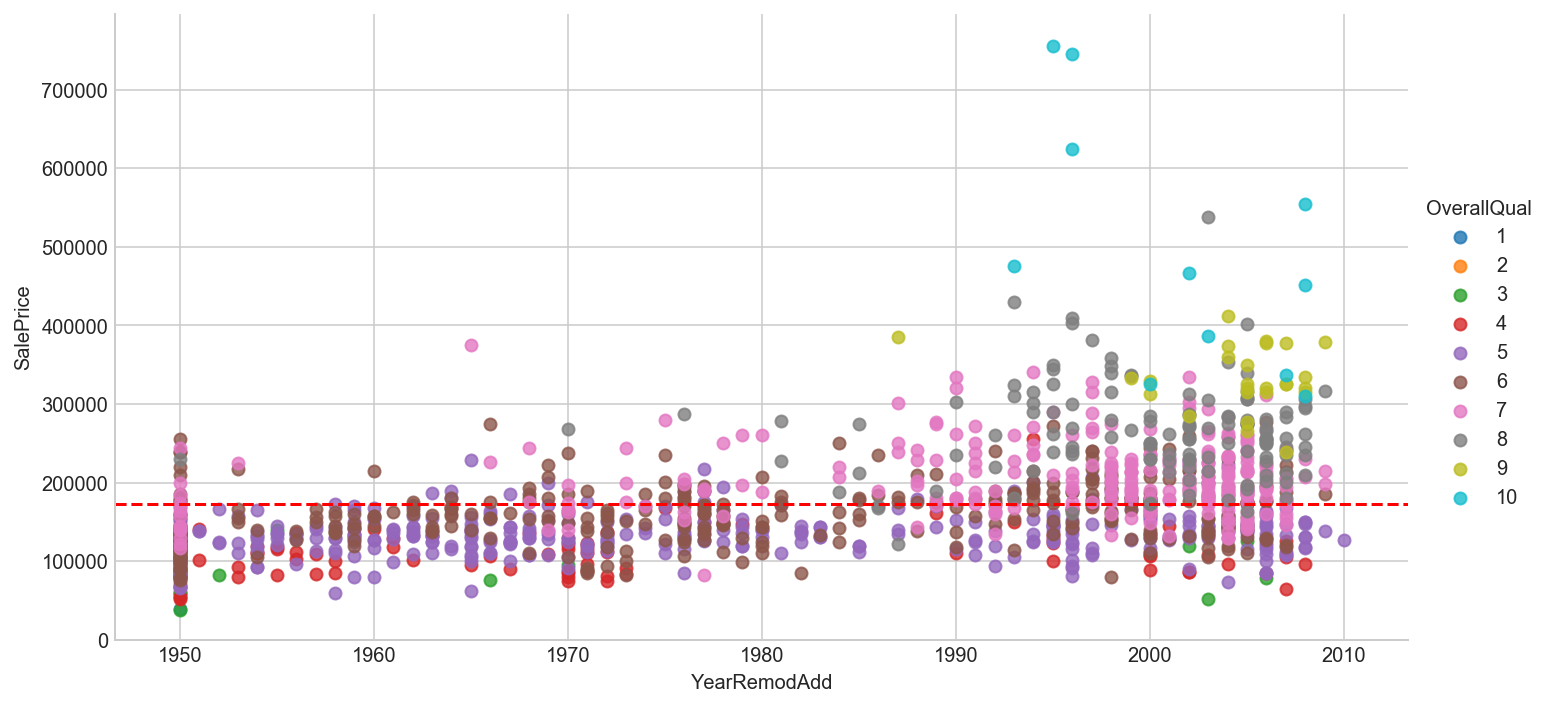

In [30]:
sns.lmplot(data=df, x='YearRemodAdd', y='SalePrice', hue='OverallQual', fit_reg=False, size=5, aspect=2)
plt.axhline(y=np.mean(df['SalePrice']), linestyle='dashed', color='r', label='Mean of Sale Price')
plt.show()

In [31]:
# Replace all the NAs with 0s in the main df
df[['LotFrontage','MasVnrArea','GarageYrBlt']] = df[['LotFrontage','MasVnrArea','GarageYrBlt']].replace(to_replace='NA', value=-99999)
df[['LotFrontage','MasVnrArea','GarageYrBlt']] = df[['LotFrontage','MasVnrArea','GarageYrBlt']].apply(pd.to_numeric)

In [32]:
df.dtypes.value_counts()

object    43
int64     38
dtype: int64

In [33]:
# MSSubClass shouldn't be an int64 column...
df['MSSubClass'] = df['MSSubClass'].astype('object')

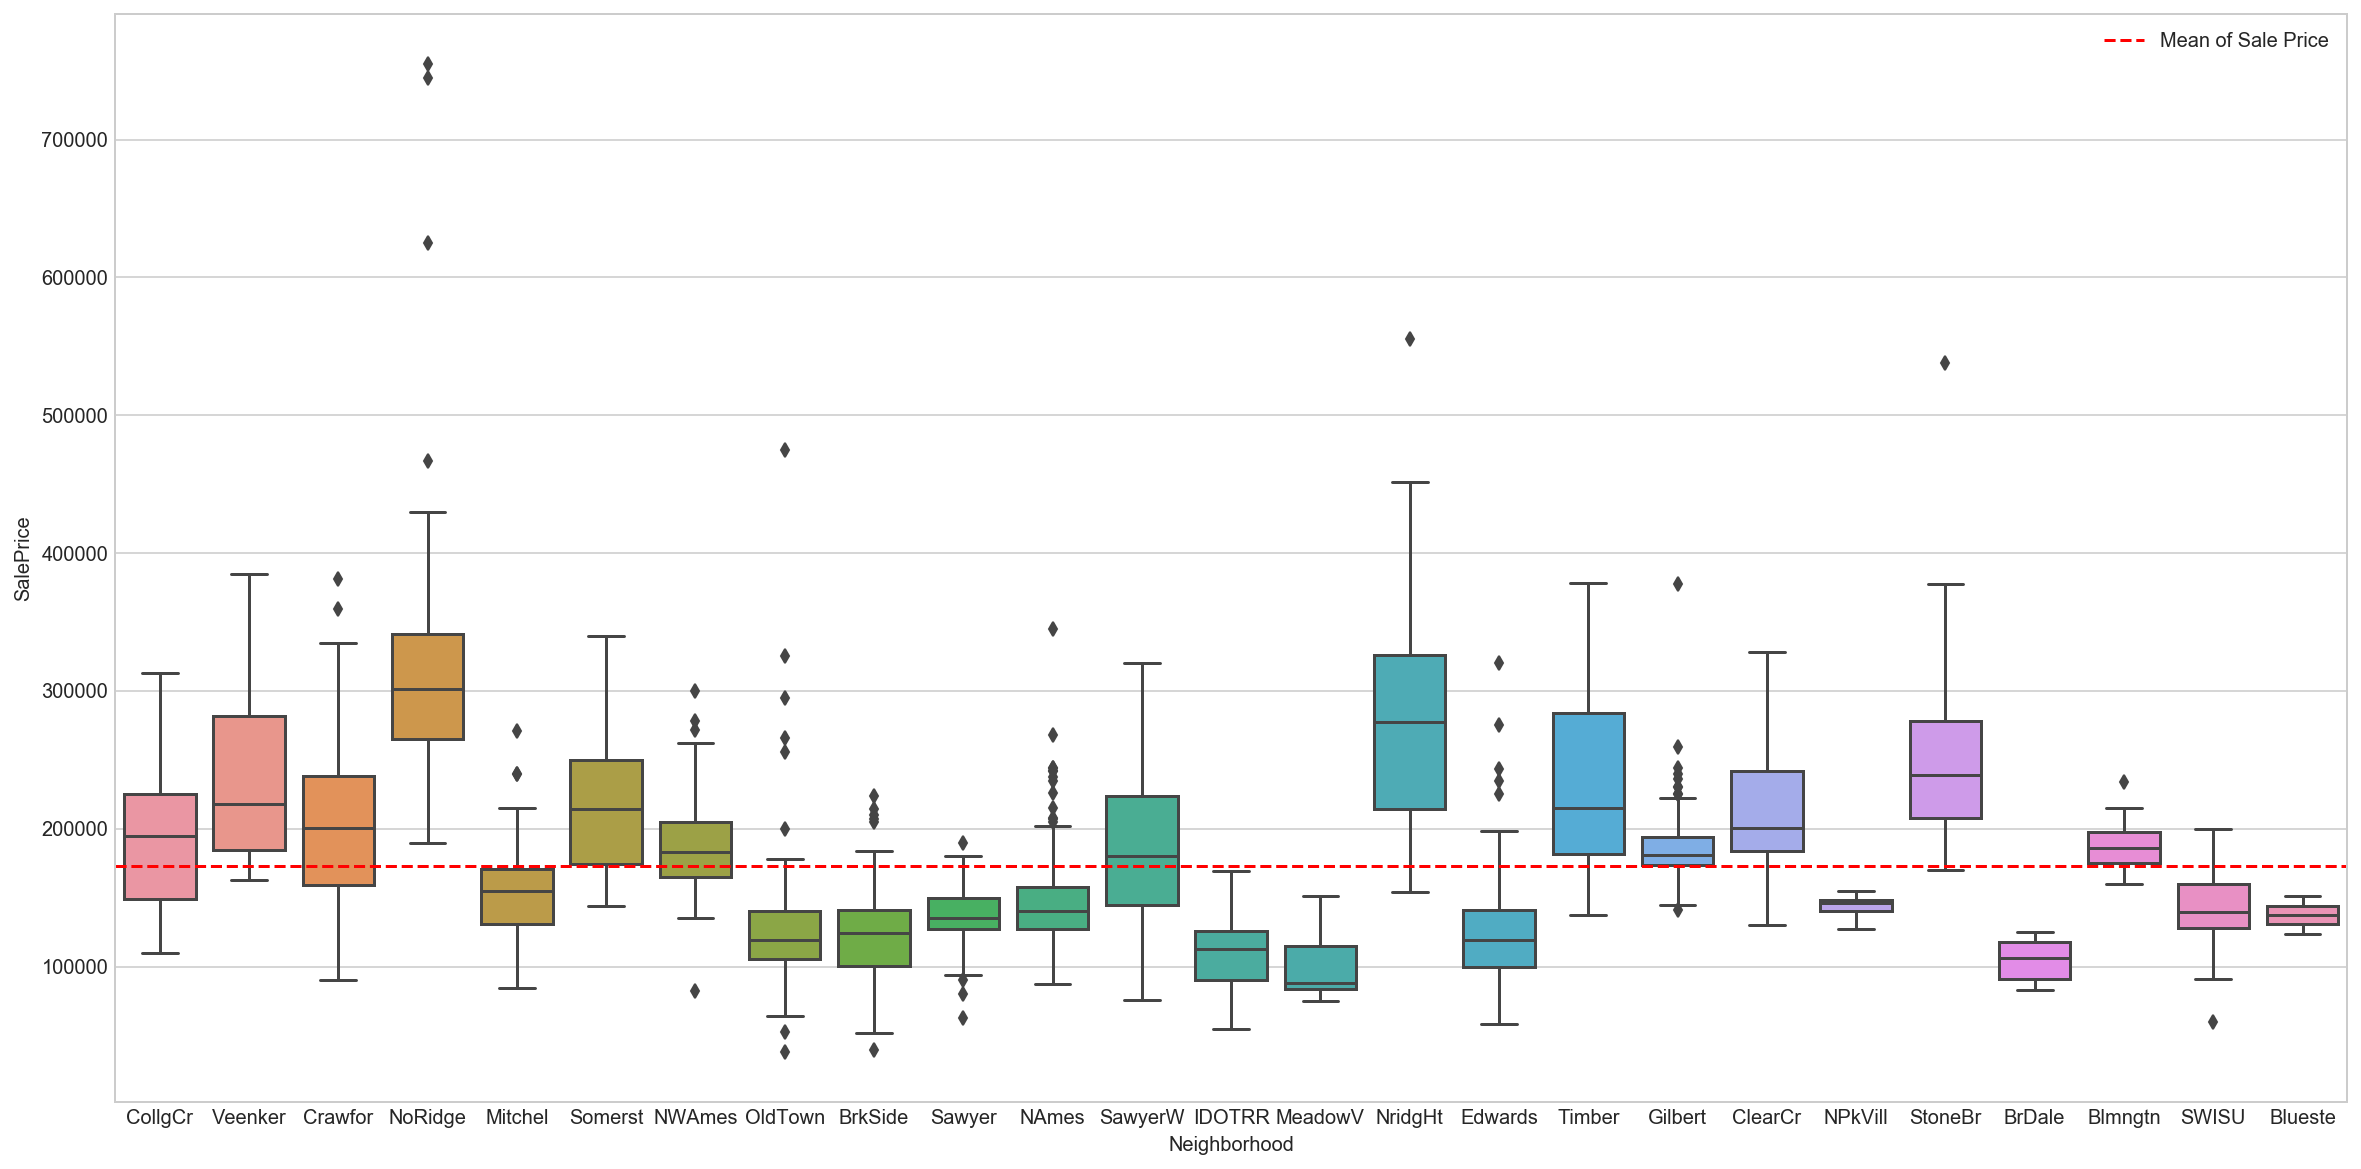

In [34]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='Neighborhood', y='SalePrice')
plt.axhline(y=np.mean(df['SalePrice']), linestyle='dashed', color='r', label='Mean of Sale Price')
plt.legend(loc='upper right')
plt.show()

In [35]:
# Taking the mean of each group. Sum() might be affected by outliers...
# df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).to_frame('Mean_SalePrice_per_Neigh').reset_index().head(10)

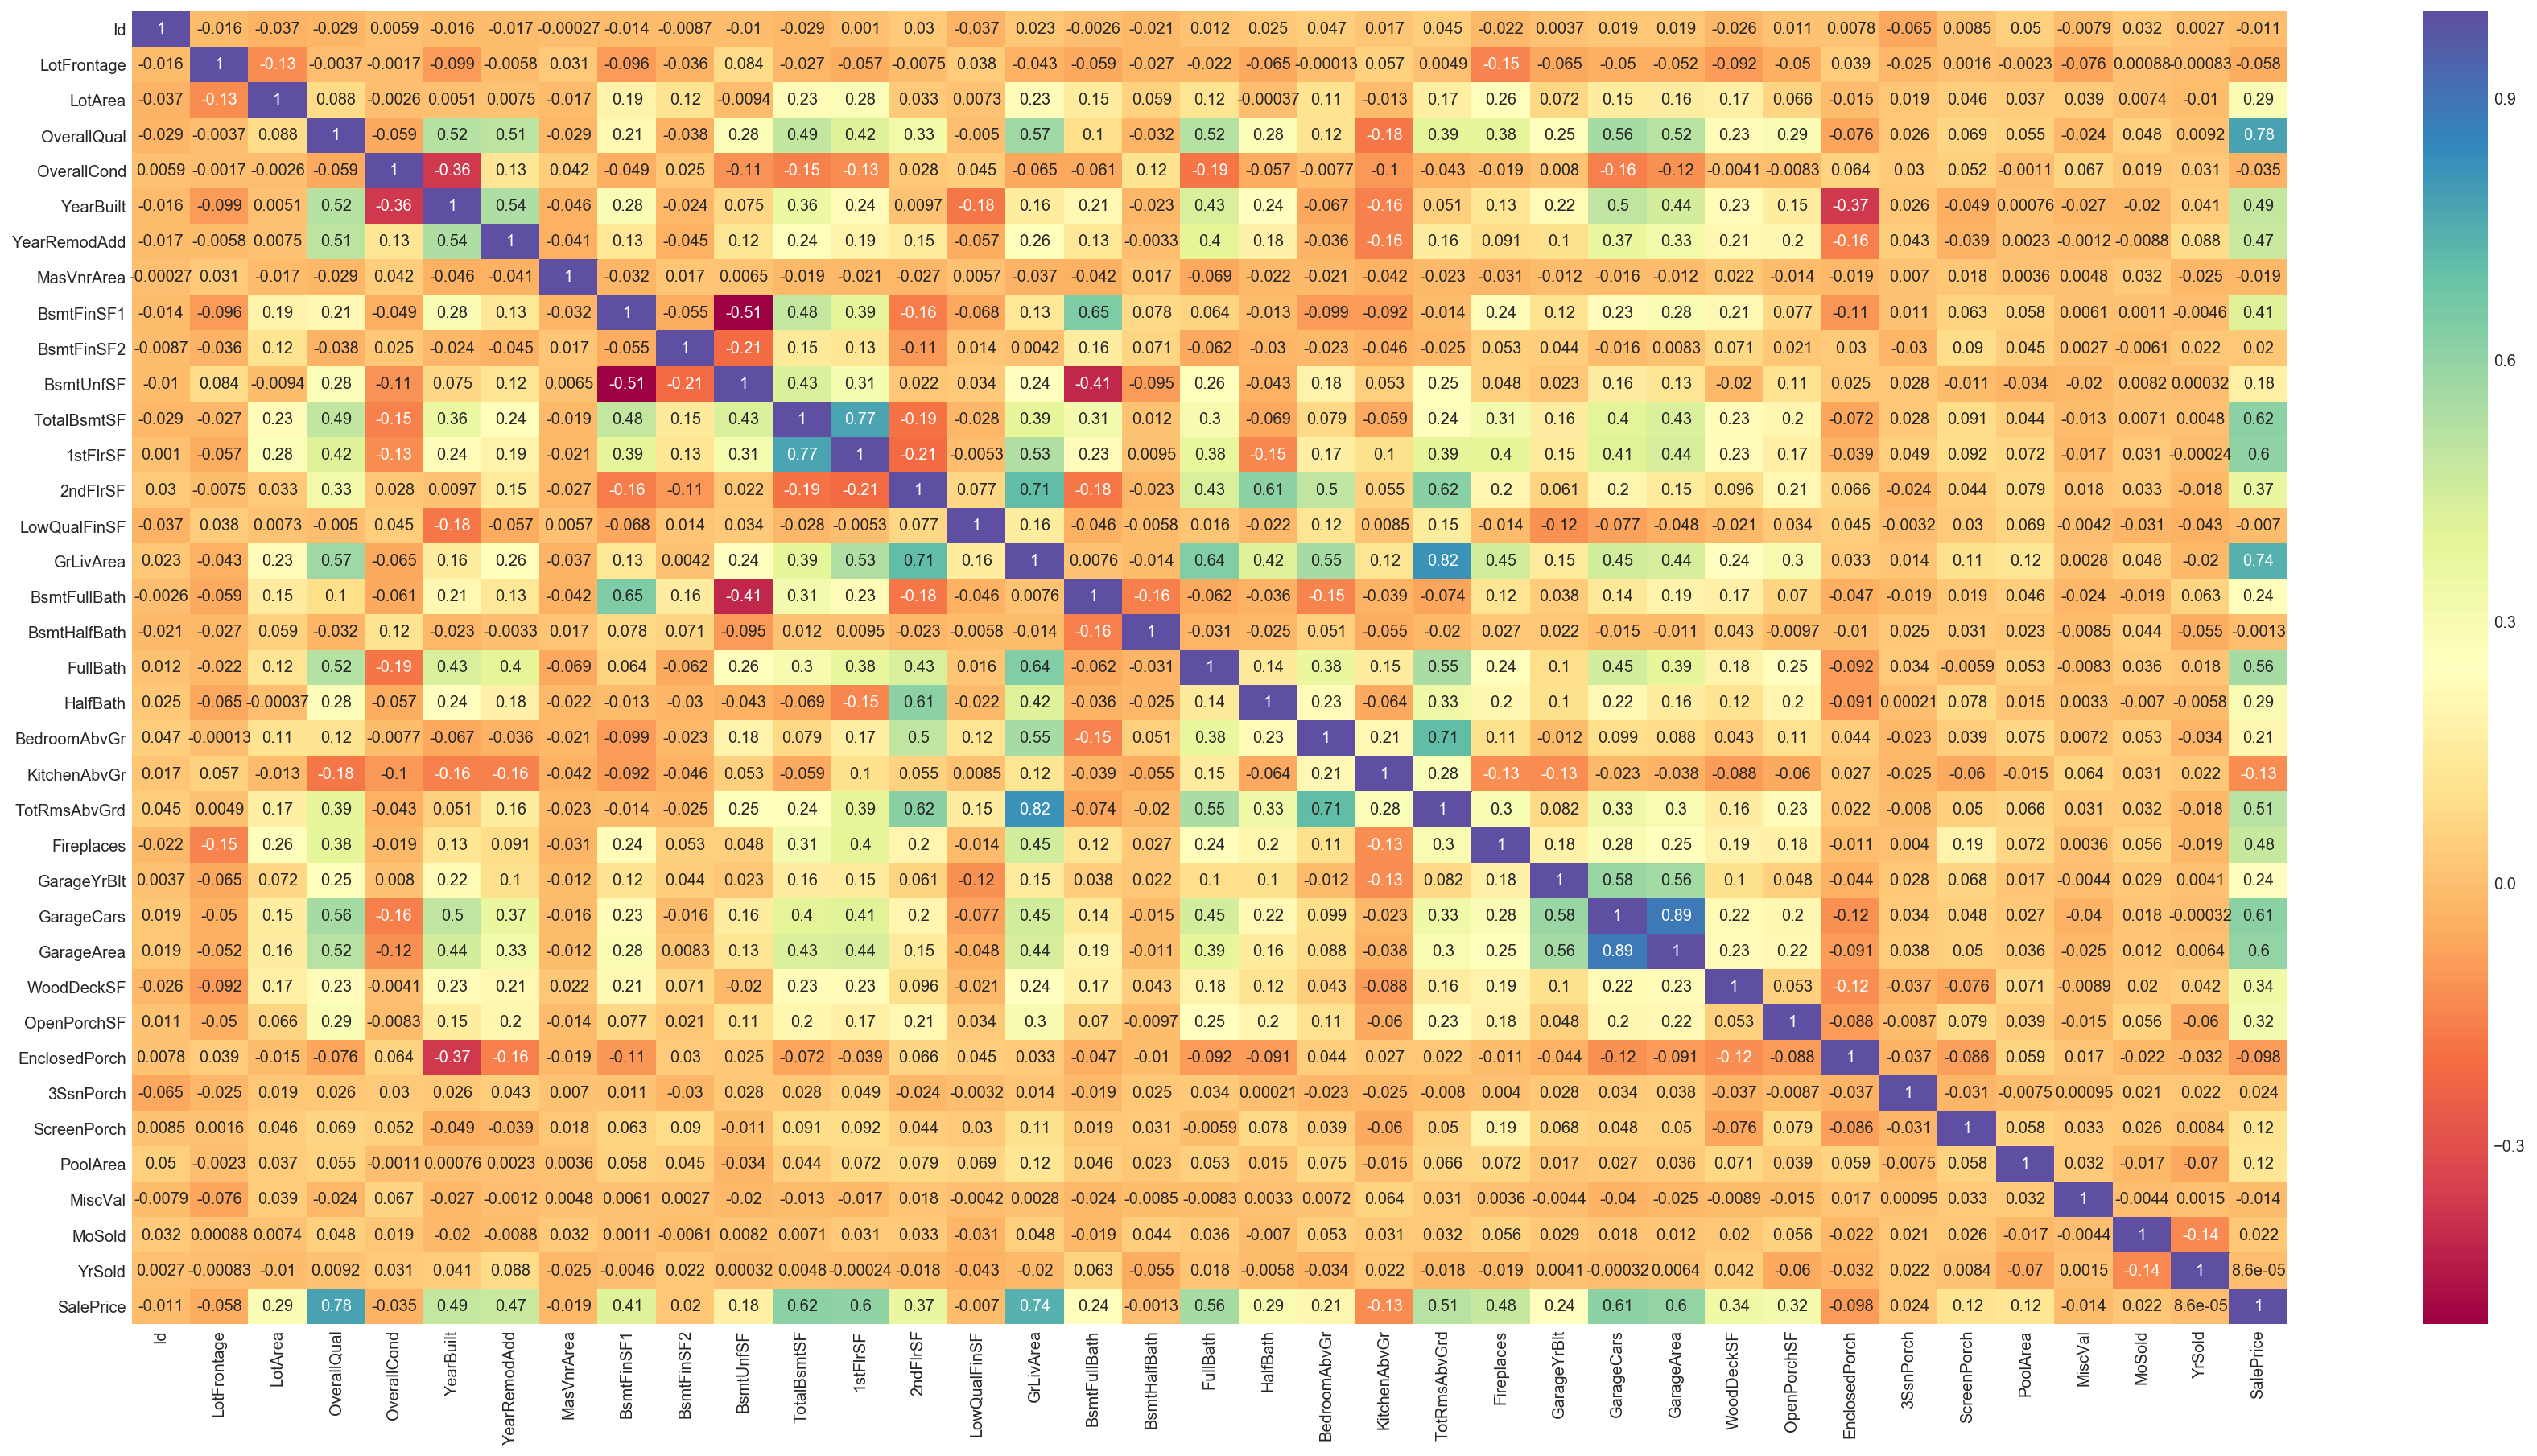

In [36]:
# plot bigger heatmap
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(), annot=True, cmap='Spectral')
plt.show()

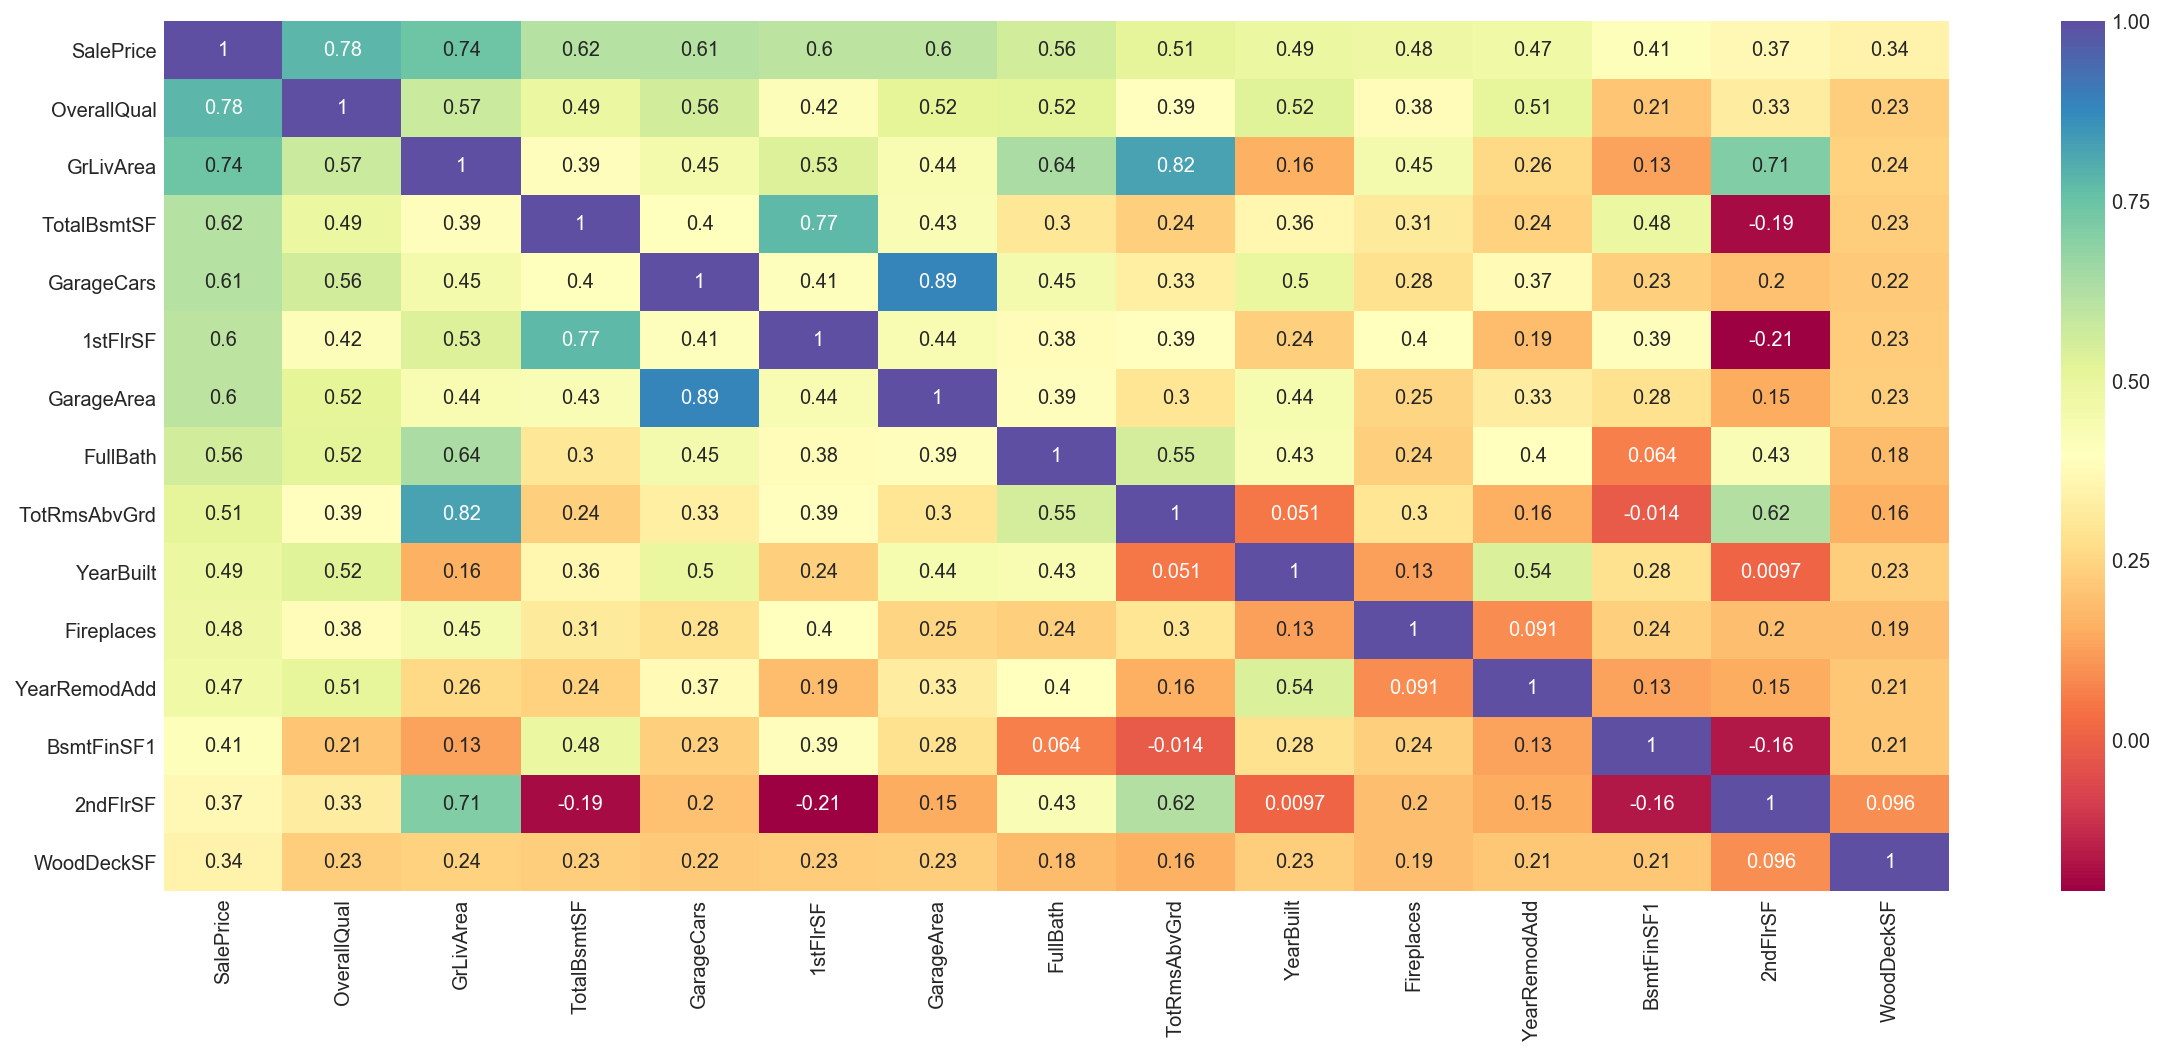

In [37]:
# Lifted from one of the posts on Kaggle. I take no credit. The only change is k=15 instead of k=10
#
# SalePrice correlation matrix
k = 15 #number of variables for heatmap
cols = df.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(20,8))
sns.heatmap(cm, annot=True, yticklabels=cols.values, xticklabels=cols.values, cmap='Spectral')
plt.show()

> So the variables that are likely to make a difference are:
> - OverallQual
> - GrLivArea (TotRmsAbvGrd is highly correlated with GrLiveArea, which makes sense--I will take GrLivArea cause of the continuous values)
> - GarageArea (because GarageCars and Area are kinda the same thing, I'll take the continous variable instead of the discrete values)
> - TotalBsmtSF
> - 1stFlrSF
> - FullBath
> - YearBuilt and YearRemodAdd (I think at this point, one of these will matter more... not both, for now I will take YearRemodAdd)

> Features that cannot be renovated:
> - GrLivArea
> - GarageArea
> - TotalBsmtSF
> - 1stFlrSF
> - FullBath (D)
> - YearBuilt 
> - BsmtQual (C)
> - Neighborhood (C)

> ----
> **Baseline**
>
> Using these selected features, we'll use a simple LinearRegression() with no optimization to see what is the score. This can be our baseline.

In [38]:
# Prepare the train and test sets

In [39]:
list_of_features = ['SalePrice','YrSold','GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','BsmtQual','Neighborhood']
features = df[list_of_features].copy()
features = pd.get_dummies(data=features, columns=['FullBath','BsmtQual','Neighborhood'], drop_first=True)
features.shape

(1328, 38)

In [40]:
train = features[features['YrSold']<2010]

In [41]:
train.shape

(1163, 38)

In [42]:
test = features[features['YrSold']==2010]

In [43]:
test.shape

(165, 38)

In [44]:
# Drop YrSold column since we don't need it anymore
train = train.drop(columns=['YrSold'])
test = test.drop(columns=['YrSold'])

In [45]:
X_train = train.iloc[:,1:]
y_train = train['SalePrice'].values

In [46]:
X_test = test.iloc[:,1:]
y_test = test['SalePrice'].values

In [47]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.8566429278144978

In [49]:
lr.intercept_

173152.52106620805

In [50]:
# Cross_val_score
np.mean(cross_val_score(lr, features.drop(['YrSold','SalePrice'], axis=1), features['SalePrice'], cv=5))

0.8260471811721167

In [51]:
lr_coef_df = pd.DataFrame({'labels':test.columns.values[1:],'coef':lr.coef_,'absolute_coef':np.abs(lr.coef_)})

In [52]:
lr_coef_df.sort_values(by='coef', ascending=True).head()

,absolute_coef,coef,labels
11,30368.018174,-30368.018174,BsmtQual_TA
9,25038.091694,-25038.091694,BsmtQual_Gd
8,10317.534422,-10317.534422,BsmtQual_Fa
10,9188.348599,-9188.348599,BsmtQual_NA
6,5841.365927,-5841.365927,FullBath_2


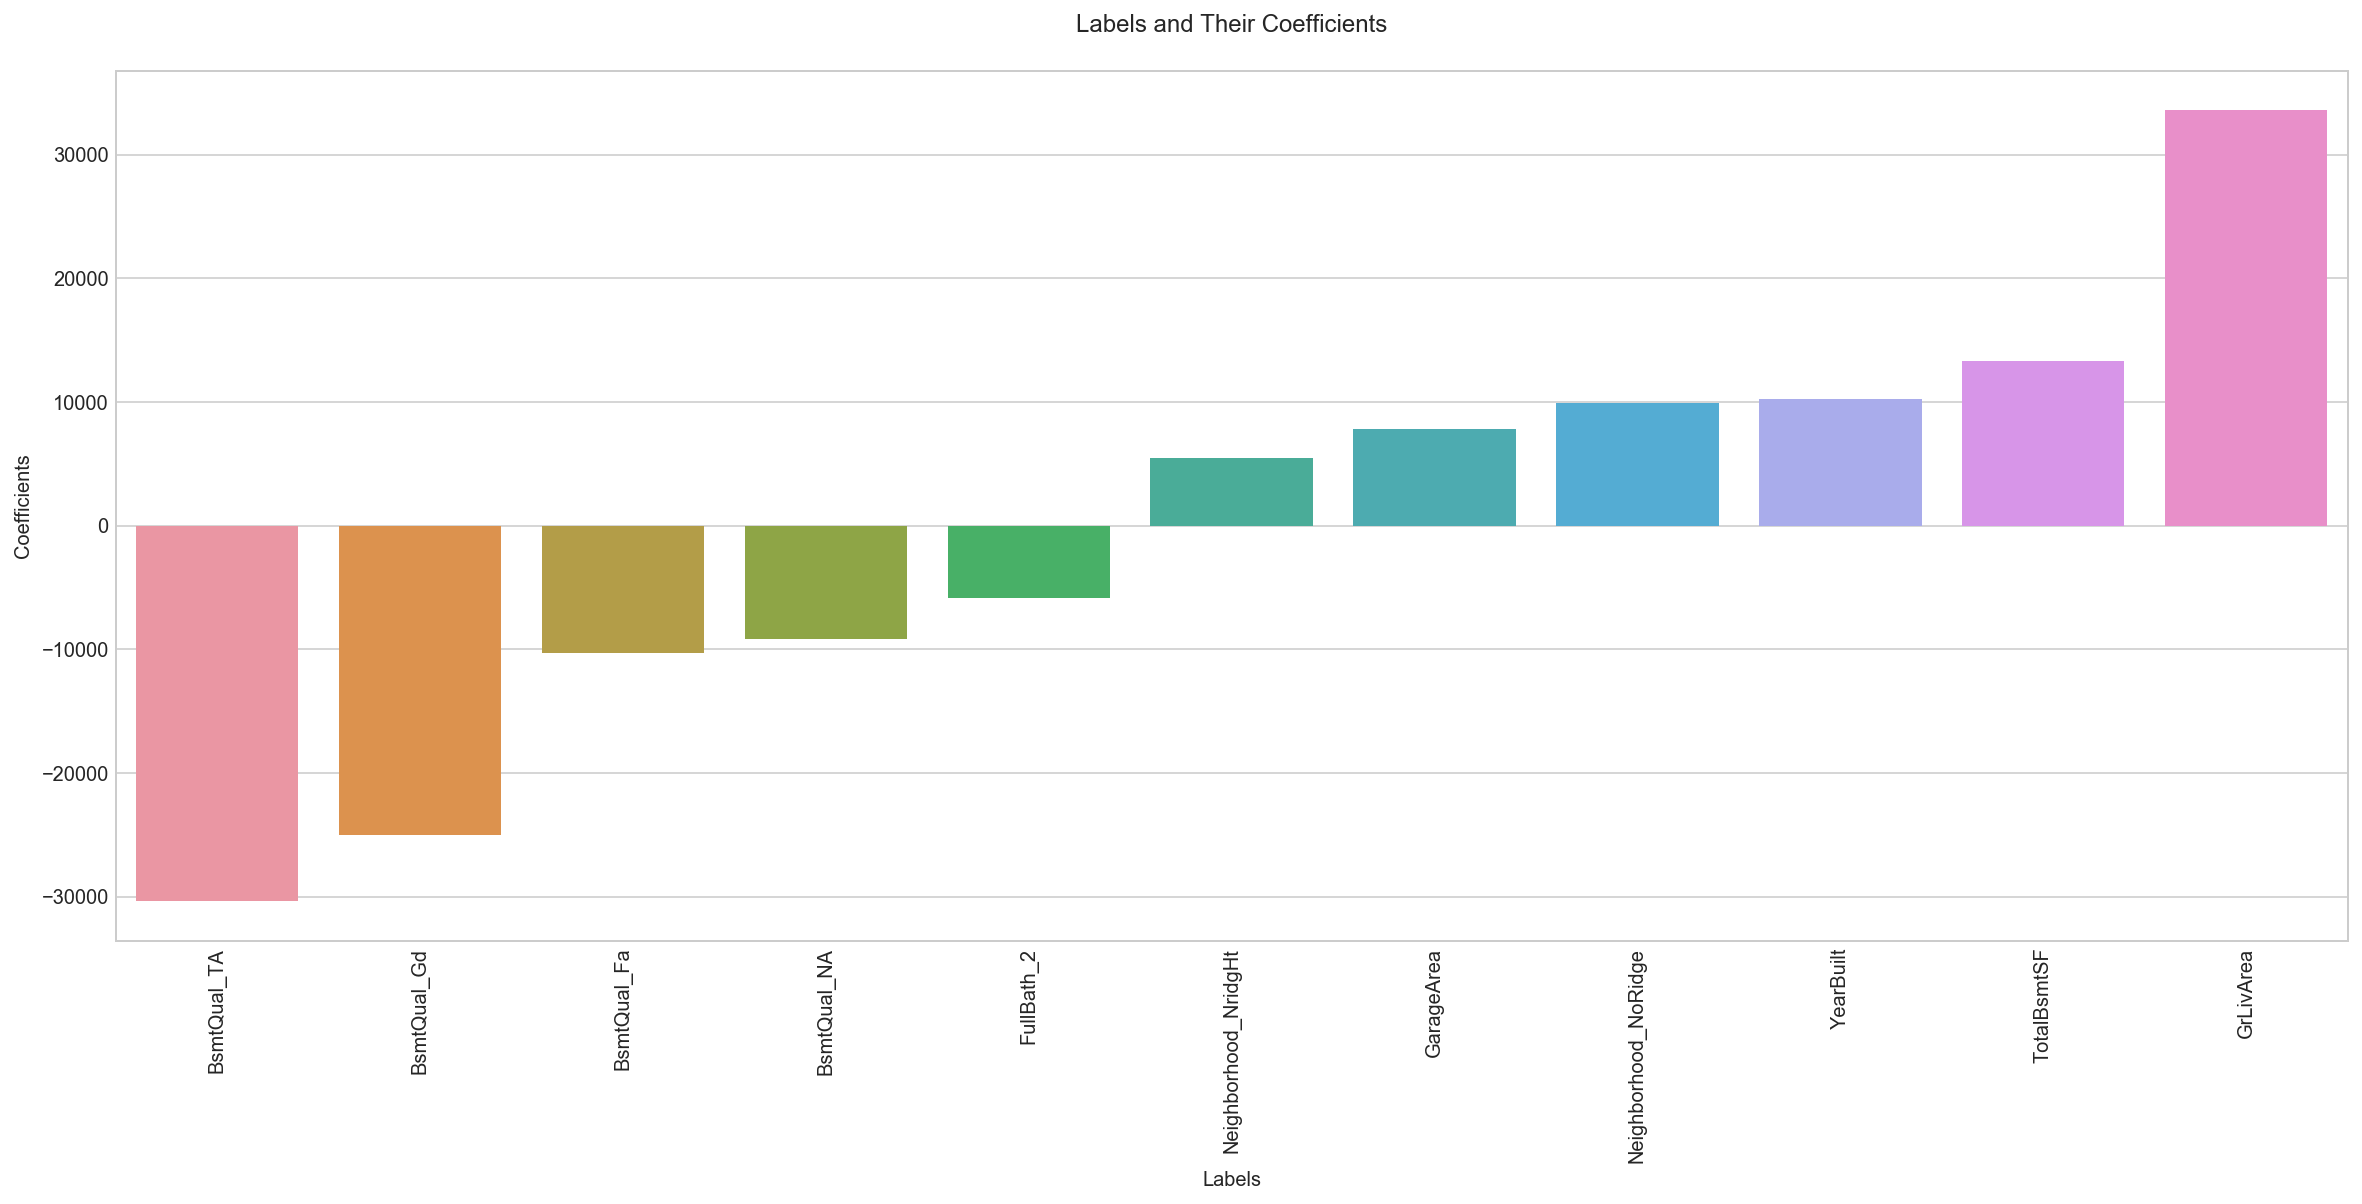

In [53]:
plt.figure(figsize=(20,8))
sns.barplot(data=lr_coef_df[(lr_coef_df['absolute_coef']!=0) & (lr_coef_df['absolute_coef']>5000)].sort_values(by='coef', ascending=True), x='labels', y='coef')

plt.title('Labels and Their Coefficients\n')
plt.ylabel('Coefficients')
plt.xlabel('Labels')
plt.xticks(rotation='vertical')
plt.show()

In [54]:
lr_yhat = lr.predict(X_test)

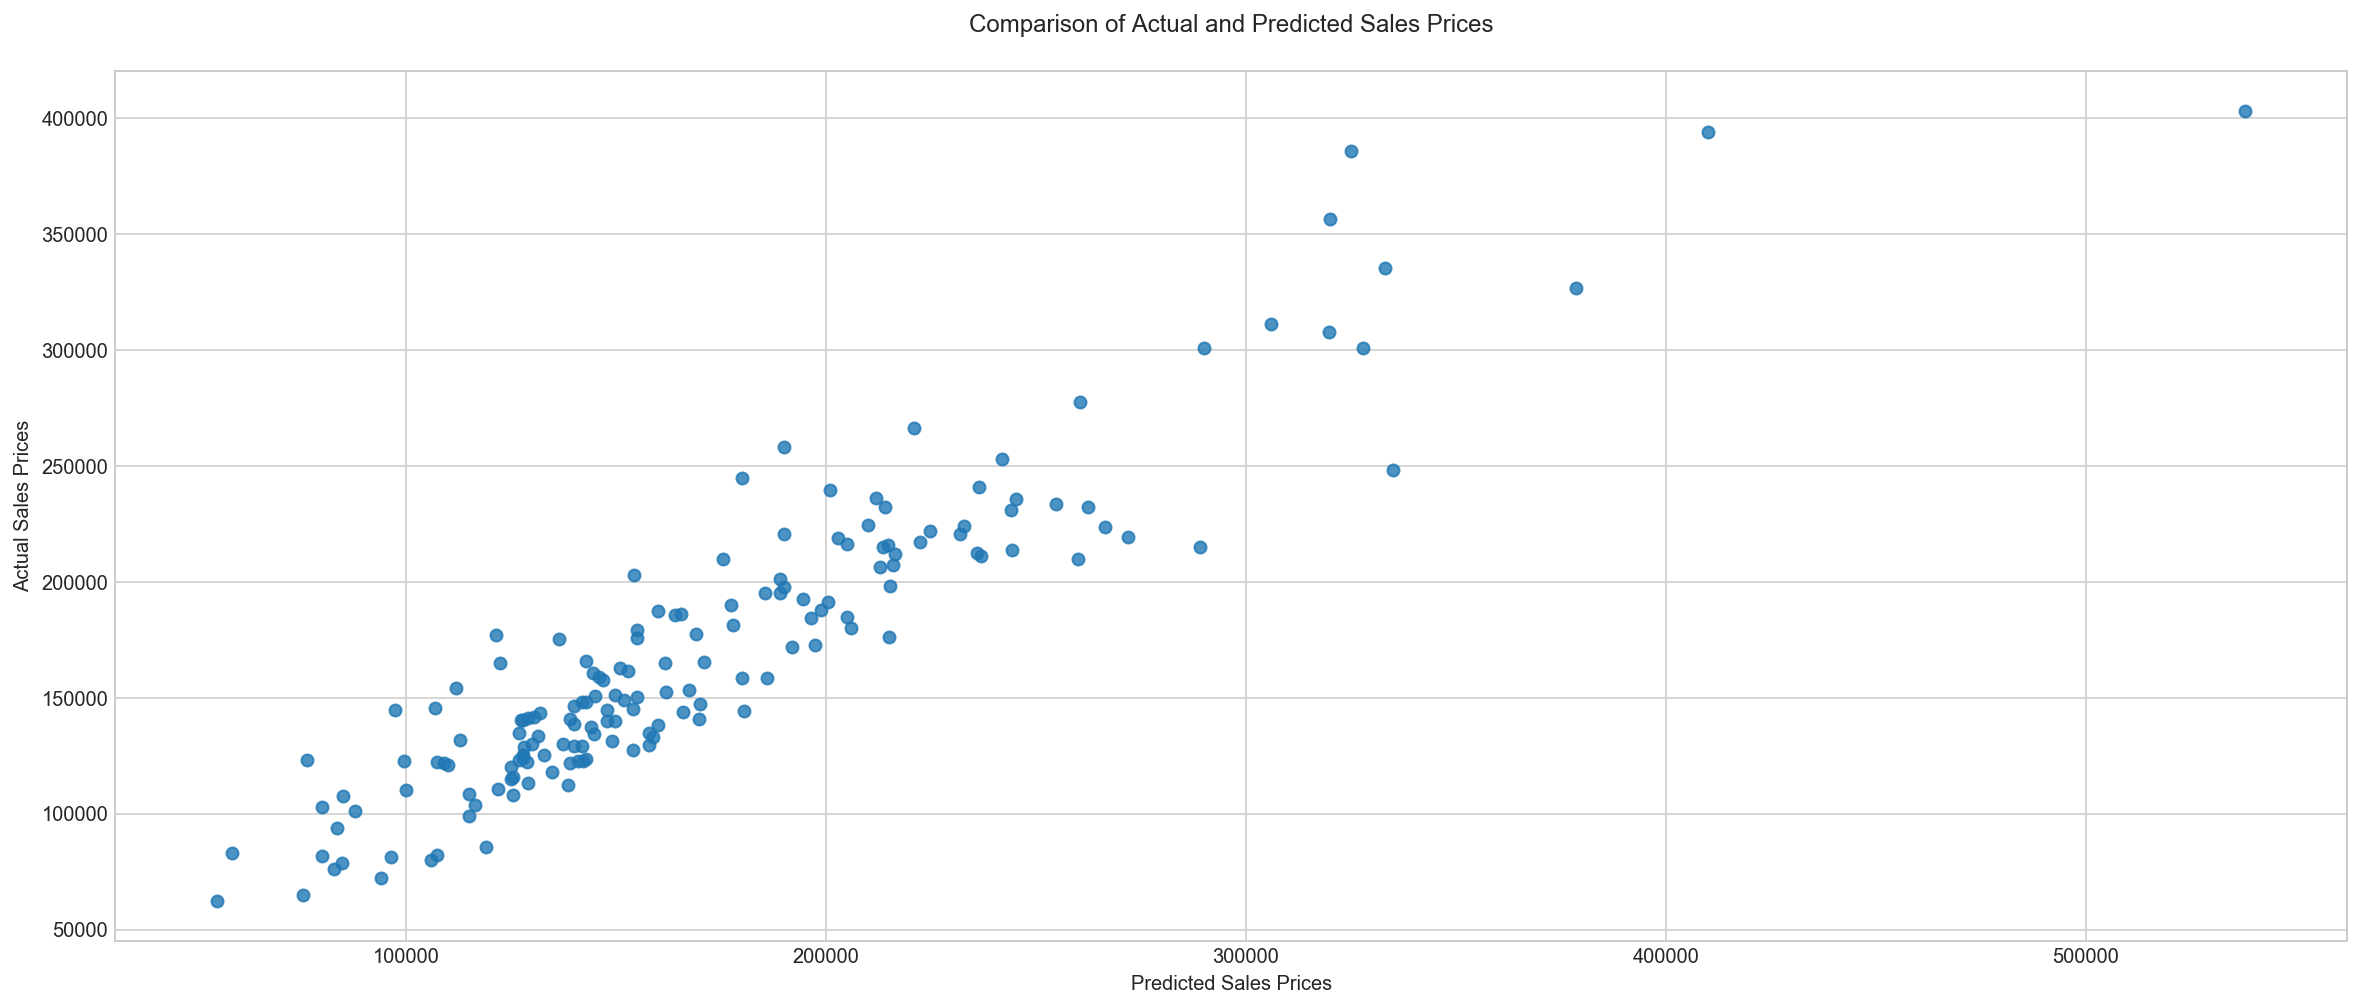

In [55]:
plt.figure(figsize=(20,8))
sns.regplot(x=y_test, y=lr_yhat, fit_reg=False)

plt.title('Comparison of Actual and Predicted Sales Prices\n')
plt.xlabel('Predicted Sales Prices')
plt.ylabel('Actual Sales Prices')
plt.show()

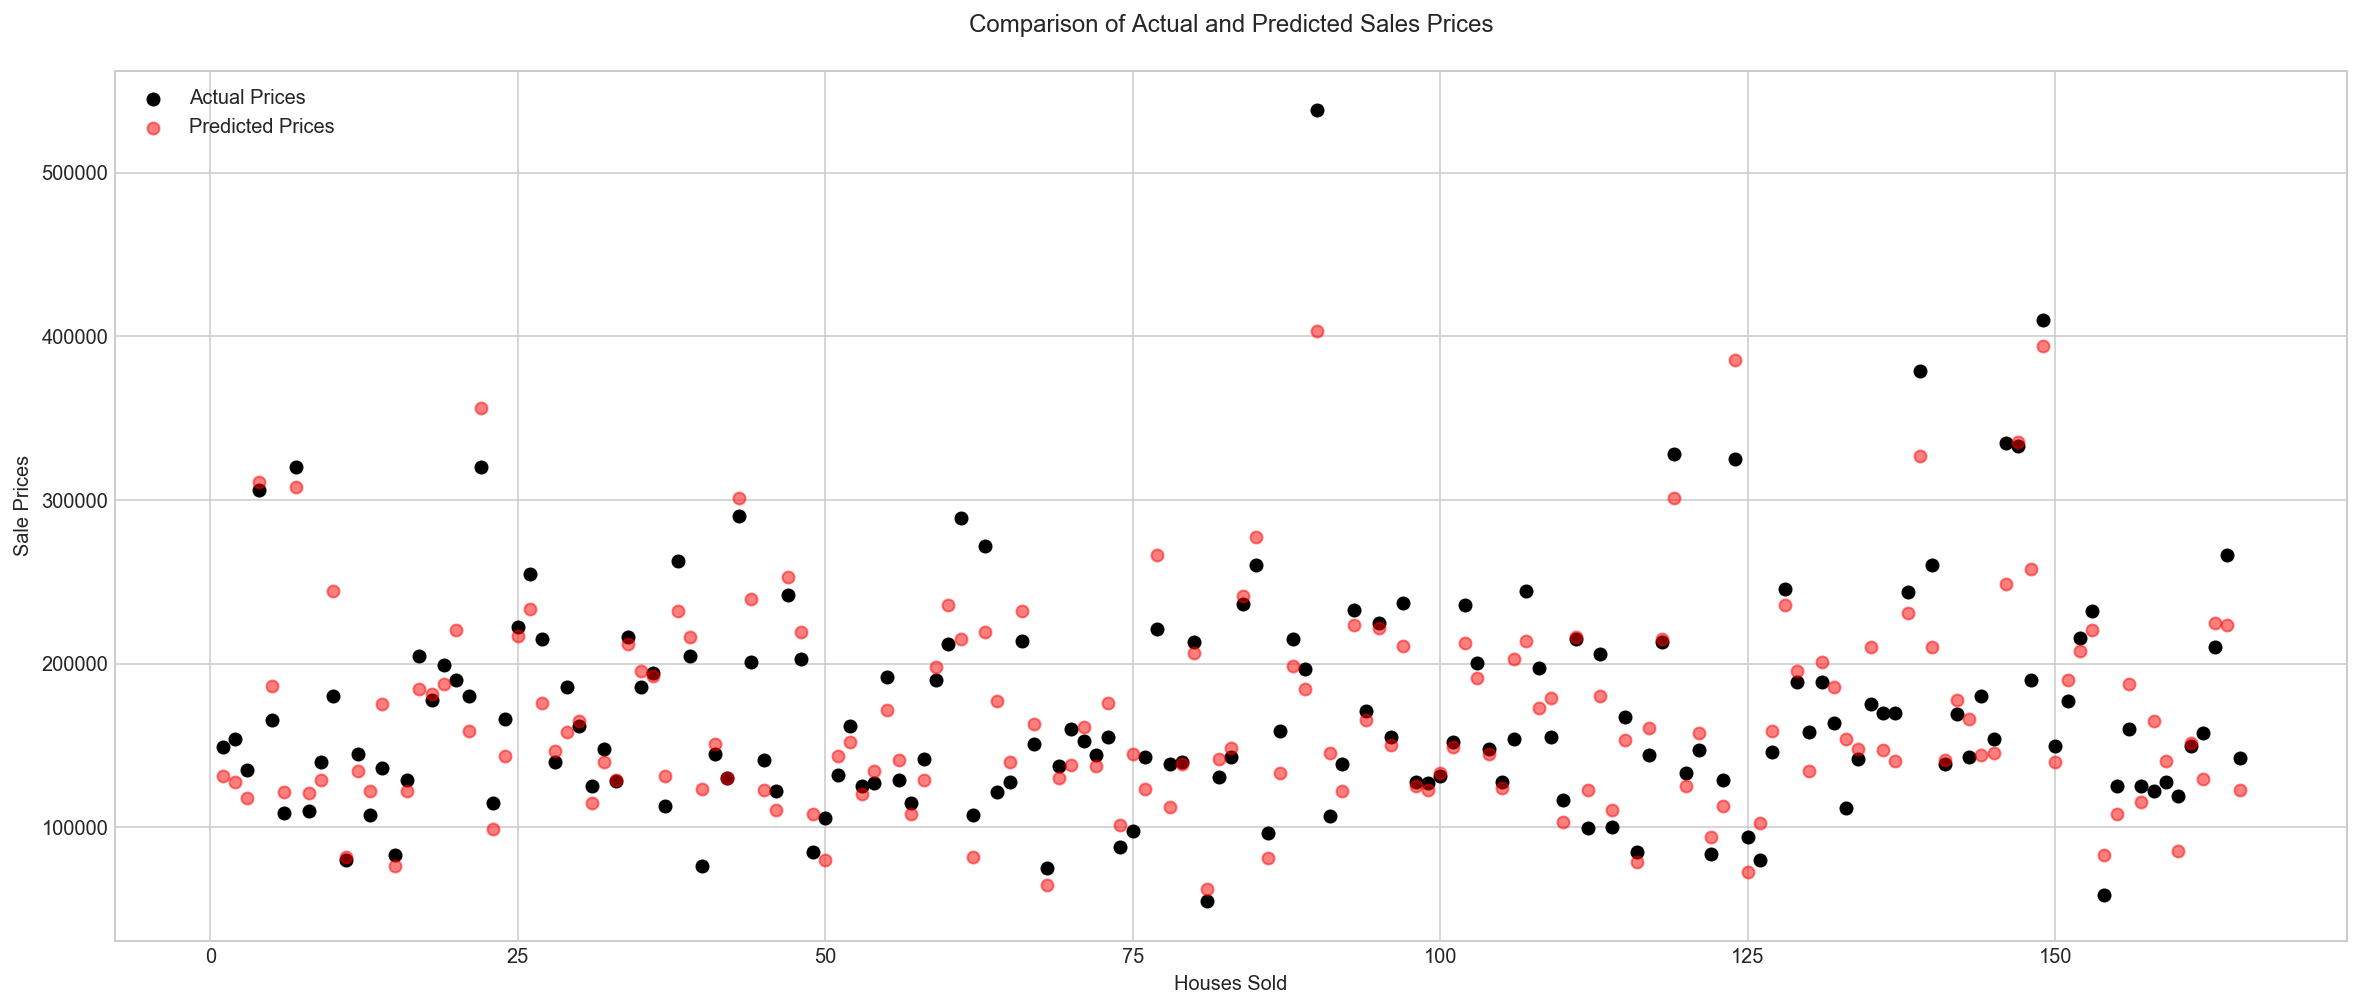

Mean squared error: 688673343.475
R^2: 0.856642927814


In [56]:
plt.figure(figsize=(20,8))
plt.scatter(range(1,166), y_test,  color='black', label='Actual Prices')
plt.scatter(range(1,166), lr_yhat, color='red', alpha=0.5, label='Predicted Prices')

plt.legend(loc='upper left')

plt.title('Comparison of Actual and Predicted Sales Prices\n')
plt.xlabel('Houses Sold')
plt.ylabel('Sale Prices')
plt.show()

print('Mean squared error: {}'.format(mean_squared_error(y_test, lr_yhat)))
print('R^2: {}'.format(lr.score(X_test,y_test)))

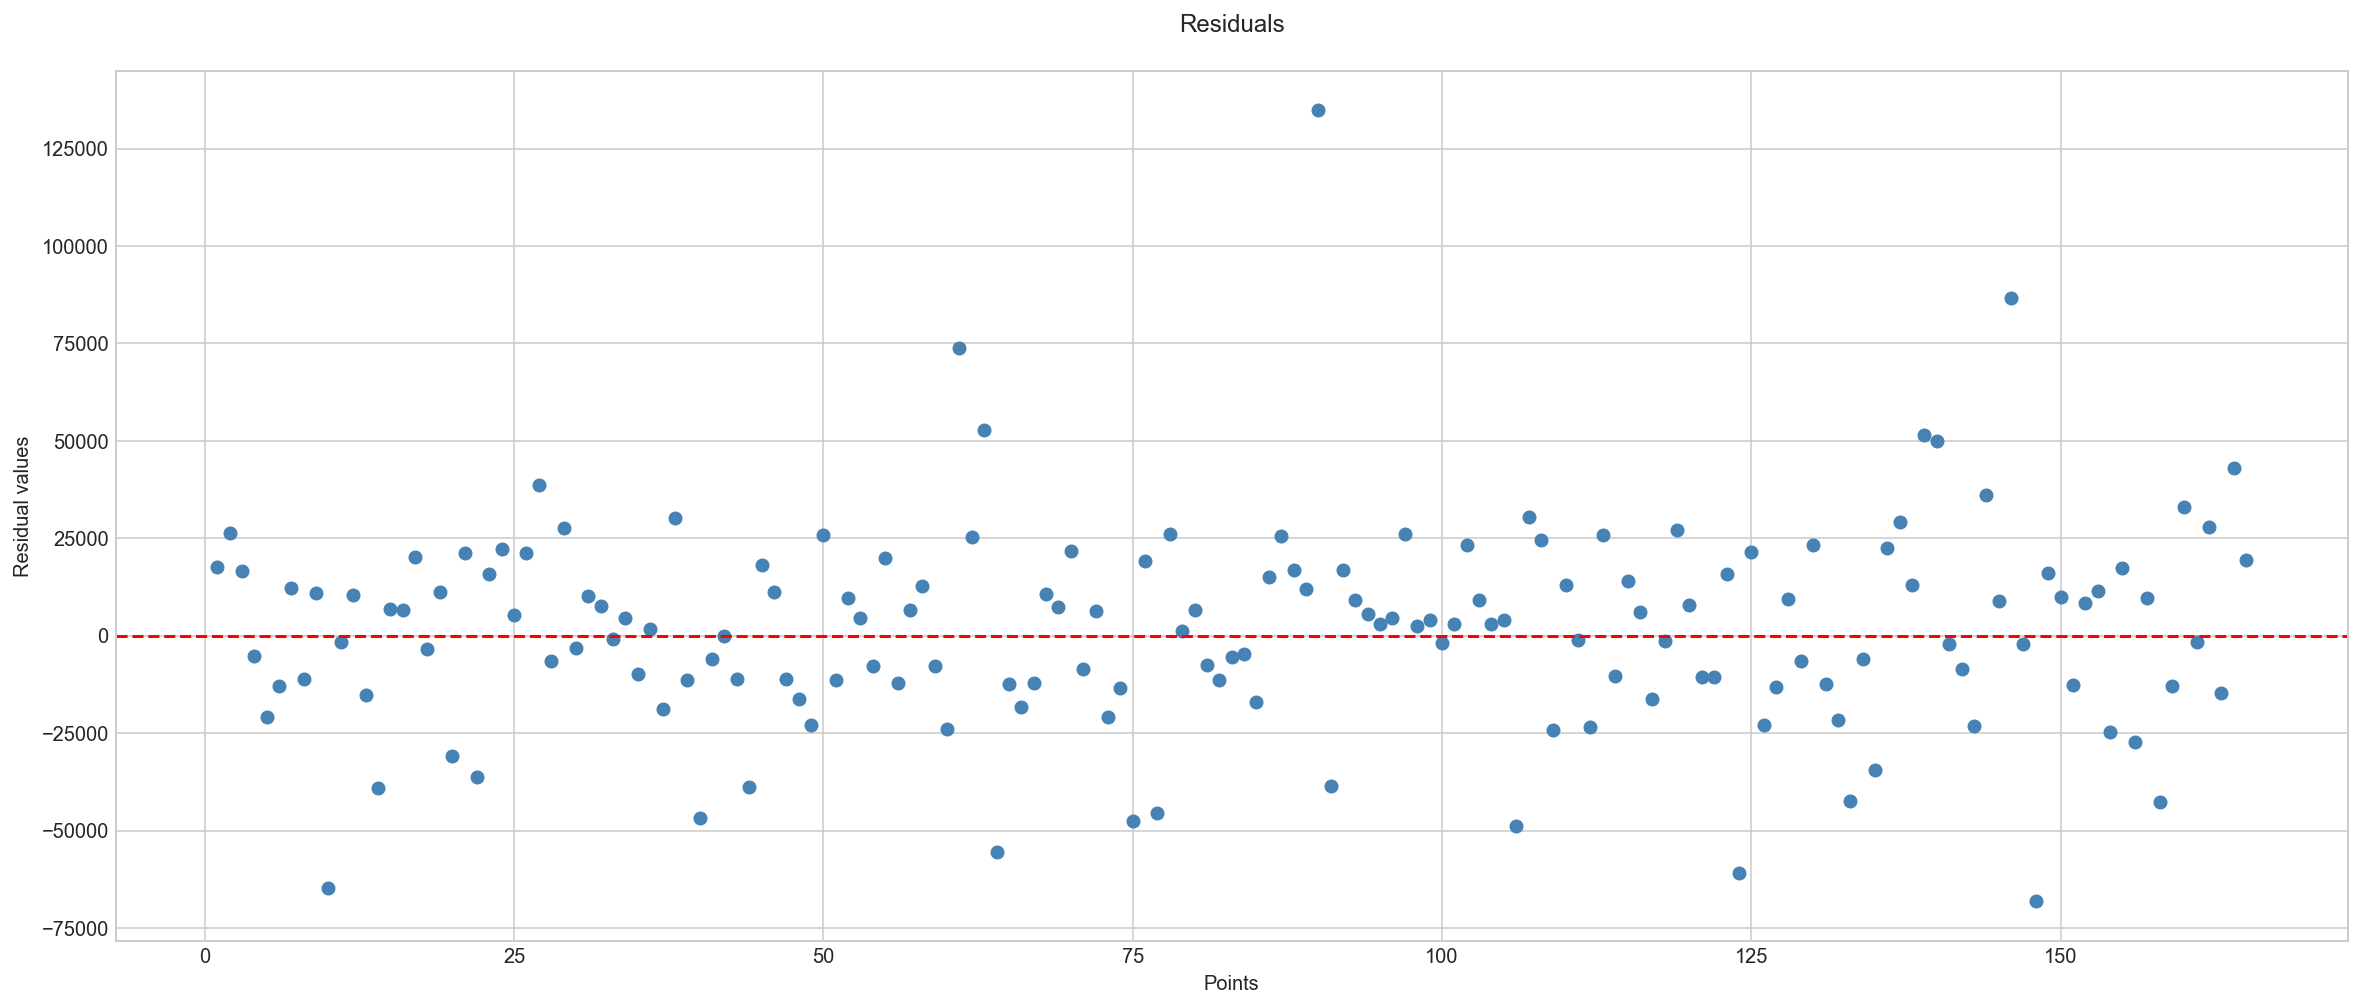

In [57]:
plt.figure(figsize=(20,8))
plt.scatter(range(1,166), (y_test-lr_yhat),  color='steelblue')
plt.axhline(y=0, color='red', linestyle='dashed')

plt.title('Residuals\n')
plt.xlabel('Points')
plt.ylabel('Residual values')
plt.show()

> Kinda random, which is good. Our linear model is kinda working.

In [58]:
# Optimizing Linear Regression
# Parameters that we can tune: alpha
# Using L2 norm that minimizes the sum of squared residuals

In [59]:
# lr_ridge = RidgeCV(alphas=np.geomspace(5.0,10.0,20), cv=5, scoring='r2')
# lr_ridge.fit(X_train,y_train)
# lr_ridge.score(X_test,y_test)

In [60]:
# lr_ridge.alpha_

In [61]:
# lr_ridge_yhat = lr_ridge.predict(X_test)

In [62]:
# plt.figure(figsize=(20,8))
# plt.scatter(range(1,166), y_test,  color='black', label='Actual Prices')
# plt.scatter(range(1,166), lr_yhat, color='red', alpha=0.7, label='Predicted Prices of LR')
# plt.scatter(range(1,166), lr_ridge_yhat, color='green', alpha=0.3, label='Predicted Prices of Ridge')


# plt.legend(loc='upper left')

# plt.title('Comparison of Actual and Predicted Sales Prices\n')
# plt.xlabel('Houses Sold')
# plt.ylabel('Sale Prices')
# plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [63]:
renovation_features = ['Utilities','OverallQual', 'OverallCond','RoofStyle','RoofMatl','Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 'ExterCond', 
                       'Foundation', 'BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinType2','Heating', 'HeatingQC','CentralAir', 'Electrical', 'BedroomAbvGr', 
                       'KitchenAbvGr', 'KitchenQual','TotRmsAbvGrd','Functional','FireplaceQu','GarageFinish','GarageQual', 'GarageCond', 'PavedDrive','PoolQC', 
                       'Fence']

In [64]:
reno_features = df[renovation_features].copy()

In [65]:
# Convert all int64 columns to dtype=category 
# One by one, as .astype('category') doesn't support multiple conversions
reno_features['OverallQual'] = reno_features['OverallQual'].astype('category')
reno_features['OverallCond'] = reno_features['OverallCond'].astype('category')
reno_features['BedroomAbvGr'] = reno_features['BedroomAbvGr'].astype('category')
reno_features['KitchenAbvGr'] = reno_features['KitchenAbvGr'].astype('category')
reno_features['TotRmsAbvGrd'] = reno_features['TotRmsAbvGrd'].astype('category')

In [66]:
reno_features = pd.get_dummies(reno_features, drop_first=True)

In [67]:
reno_features.shape

(1328, 165)

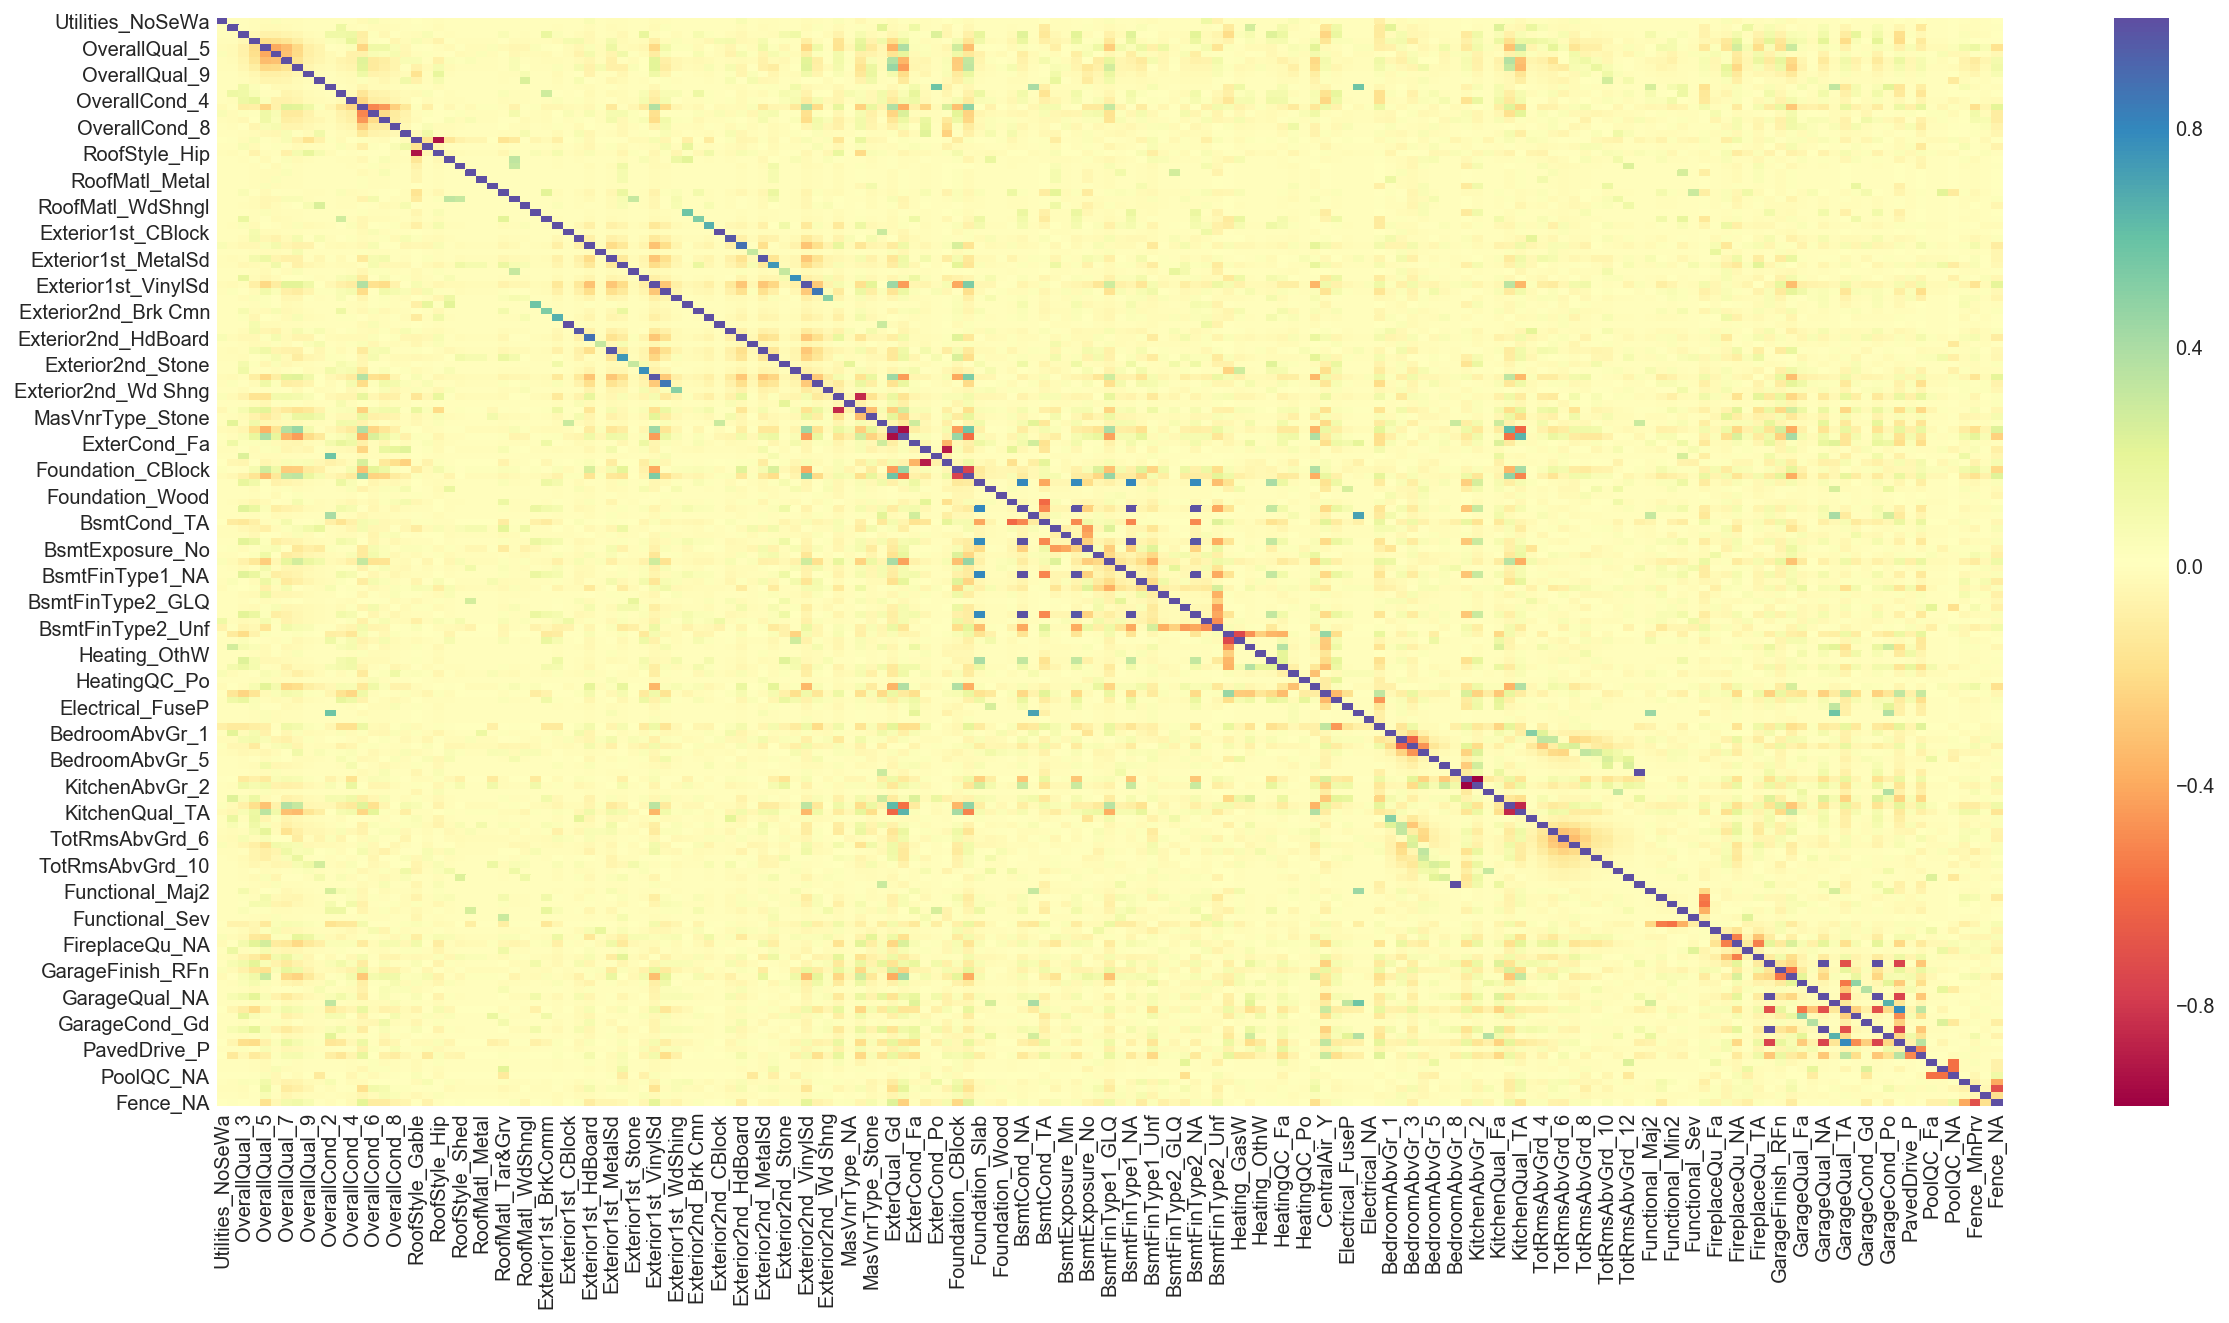

In [68]:
plt.figure(figsize=(20,10))
sns.heatmap(reno_features.corr(), cmap='Spectral')
plt.show()

In [69]:
# Get the predicted price for all 

X_all = features.iloc[:,2:].copy()
X_all = scaler.fit_transform(X_all)
lr_yhat_all = lr.predict(X_all)

In [70]:
residuals_df = pd.DataFrame({'residuals':(features['SalePrice']-lr_yhat_all)})

In [71]:
residuals_df.head()

,residuals
0,10296.222029
1,-24563.460666
2,16418.269670
3,-48520.324294
4,-51794.460609


In [72]:
residuals_df.describe()

,residuals
count,1328.000000
mean,-67.938988
std,28128.769774
min,-119612.458761
25%,-13596.451080
50%,406.584790
75%,14148.363878
max,197647.269218


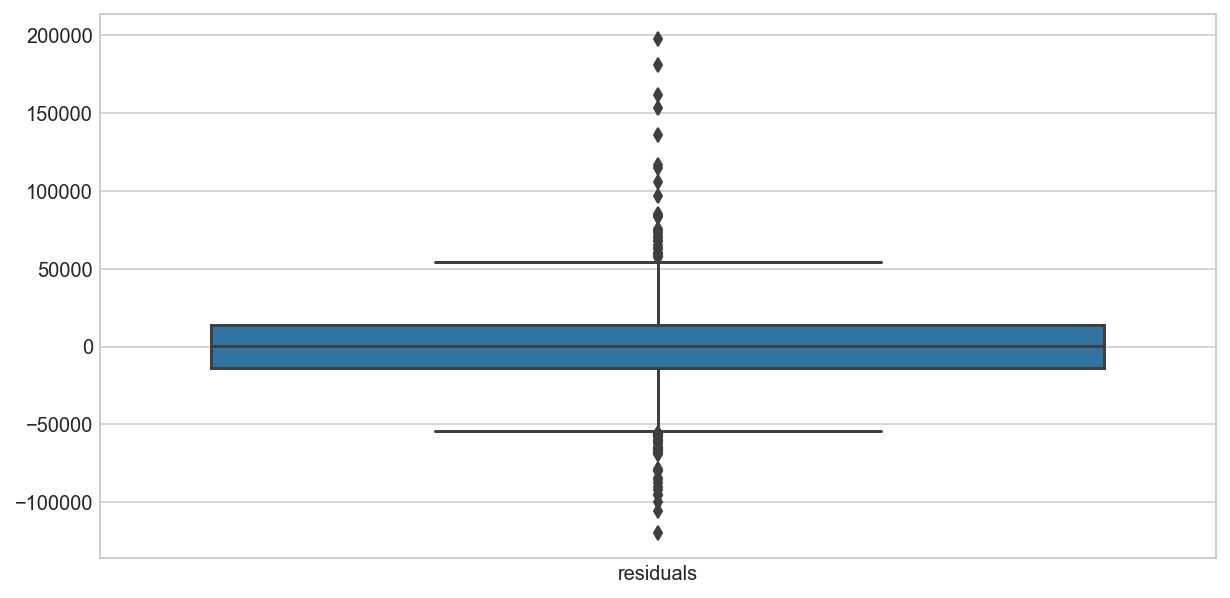

In [73]:
plt.figure(figsize=(10,5))
sns.boxplot(data=residuals_df)
plt.show()

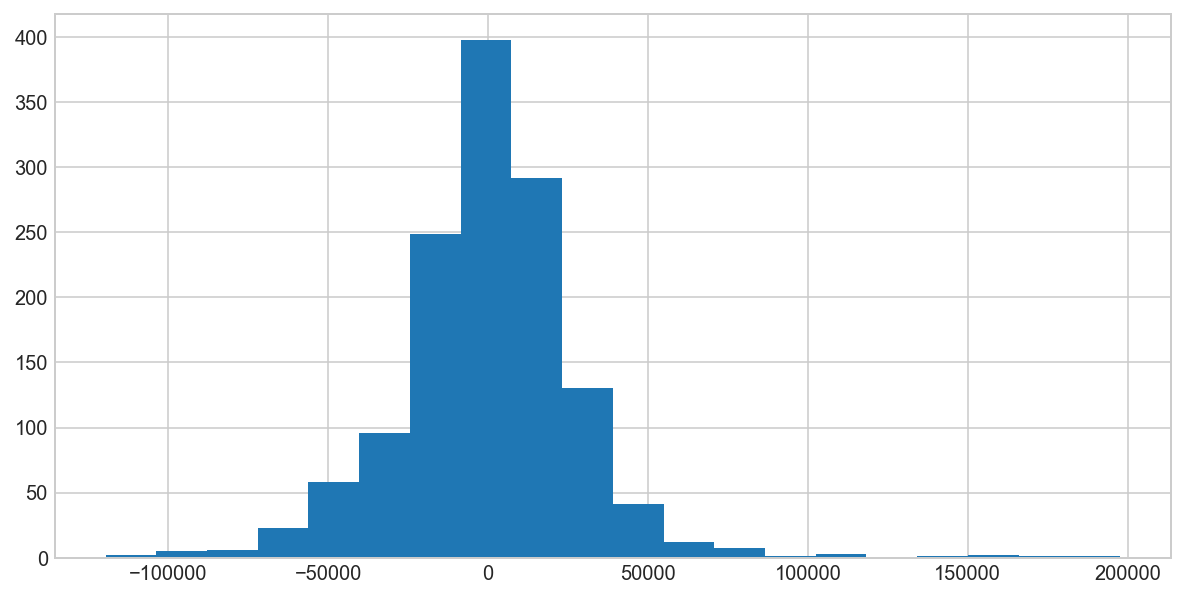

In [74]:
plt.figure(figsize=(10,5))
plt.hist(residuals_df['residuals'], bins=20)
plt.show()

In [75]:
cutoff = np.median(residuals_df['residuals'])

In [76]:
criteria1 = (residuals_df['residuals'] > cutoff)
criteria2 = (residuals_df['residuals'] < cutoff)

In [77]:
residuals_df.loc[criteria1, 'residual_cat'] = 1
residuals_df.loc[criteria2, 'residual_cat'] = 0

In [78]:
residuals_df['residual_cat'] = residuals_df['residual_cat'].astype('int64')

In [79]:
residuals_df.head()

,residuals,residual_cat
0,10296.222029,1
1,-24563.460666,0
2,16418.269670,1
3,-48520.324294,0
4,-51794.460609,0


In [80]:
reno_features = pd.concat([reno_features,residuals_df['residual_cat']], axis=1)

> ----
> **Classification Baseline**
>
> Baseline and KNN

In [81]:
# Baseline using .value_counts()
reno_features['residual_cat'].value_counts()

1    664
0    664
Name: residual_cat, dtype: int64

In [82]:
1 - float(645)/float((reno_features['residual_cat'].count()))

0.5143072289156627

In [83]:
# Train and Test matrix
X = reno_features.iloc[:,:-1]
y = reno_features['residual_cat'].values

In [84]:
X = scaler.fit_transform(X)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [86]:
# Classification with KNN, no optimization (k=5)
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.6144578313253012

In [87]:
# Check against cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)

0.5948450672134884

> Better than baseline.

In [88]:
clf_yhat = clf.predict(X_test)

In [89]:
print(classification_report(y_test, clf_yhat))

             precision    recall  f1-score   support

          0       0.60      0.63      0.62       163
          1       0.63      0.60      0.61       169

avg / total       0.62      0.61      0.61       332



Confusion matrix, without normalization
[[103  60]
 [ 68 101]]


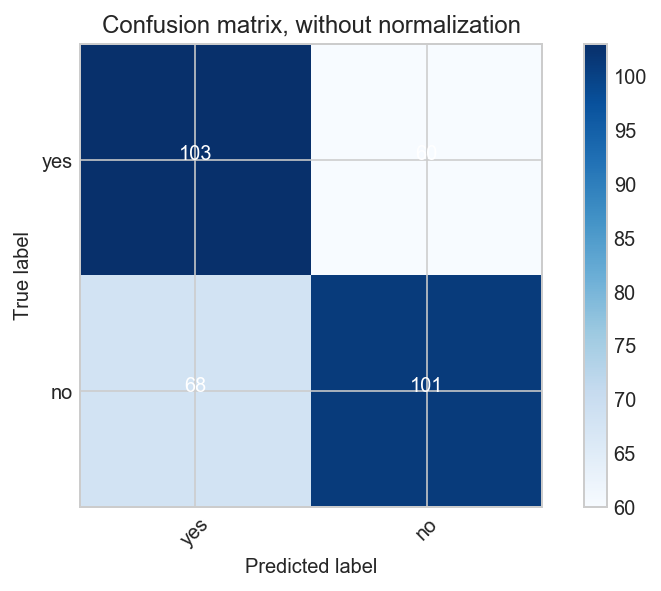

In [90]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, clf_yhat), classes=['yes','no'],
                      title='Confusion matrix, without normalization')

> Ok. Nubbad...Onto finding the best ROC_AUC score.

> ----
> **LogisticRegression**

In [91]:
# Using L1 (Lasso) parameters in LogisticRegression. I have some multicollinearity, but I have tons of potential noise.

In [92]:
lg_lasso = LogisticRegression(penalty='l1')
lg_lasso.fit(X_train,y_train)
lg_lasso.score(X_test,y_test)

0.6686746987951807

In [93]:
# Check against cross_val_score
scores_lg_lasso = cross_val_score(lg_lasso, X, y, cv=5, scoring='roc_auc')
np.mean(scores_lg_lasso)

0.7160841853281685

In [94]:
lg_lasso_yhat = clf.predict(X_test)

In [95]:
print(classification_report(y_test, lg_lasso_yhat))

             precision    recall  f1-score   support

          0       0.60      0.63      0.62       163
          1       0.63      0.60      0.61       169

avg / total       0.62      0.61      0.61       332



Confusion matrix, without normalization
[[103  60]
 [ 68 101]]


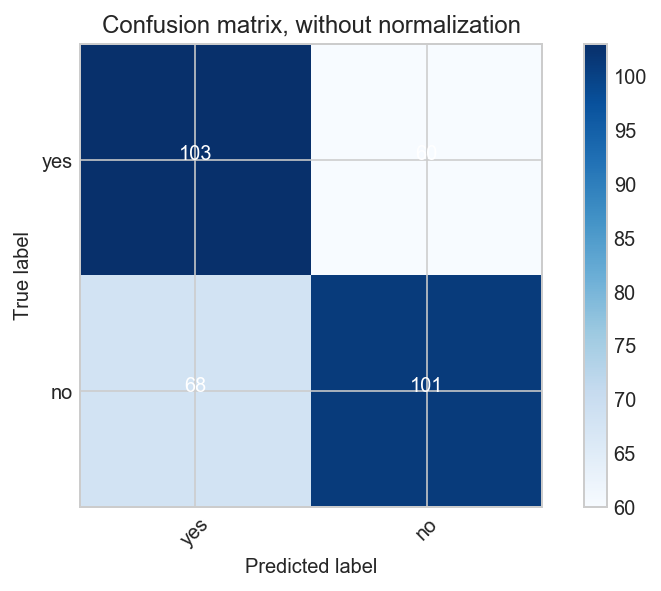

In [96]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, lg_lasso_yhat), classes=['yes','no'],
                      title='Confusion matrix, without normalization')

> L1 LogisticRegression's scores were higher although the overall precision/recall and f1-scores were the same. This means that it is at least more confident in the results. Let's look at the top 10 features...

In [97]:
lg_lasso_mean_coef = np.mean(lg_lasso.coef_, axis=0)

In [98]:
lg_lasso_coef_df = pd.DataFrame({'labels':reno_features.columns.values[1:],'coef':lg_lasso_mean_coef,
                                 'absolute_coef':np.abs(lg_lasso_mean_coef)
                                })

In [99]:
lg_lasso_coef_df.head()

,absolute_coef,coef,labels
0,0.133647,-0.133647,OverallQual_2
1,0.000000,0.000000,OverallQual_3
2,0.000000,0.000000,OverallQual_4
3,0.000000,0.000000,OverallQual_5
4,0.036159,-0.036159,OverallQual_6


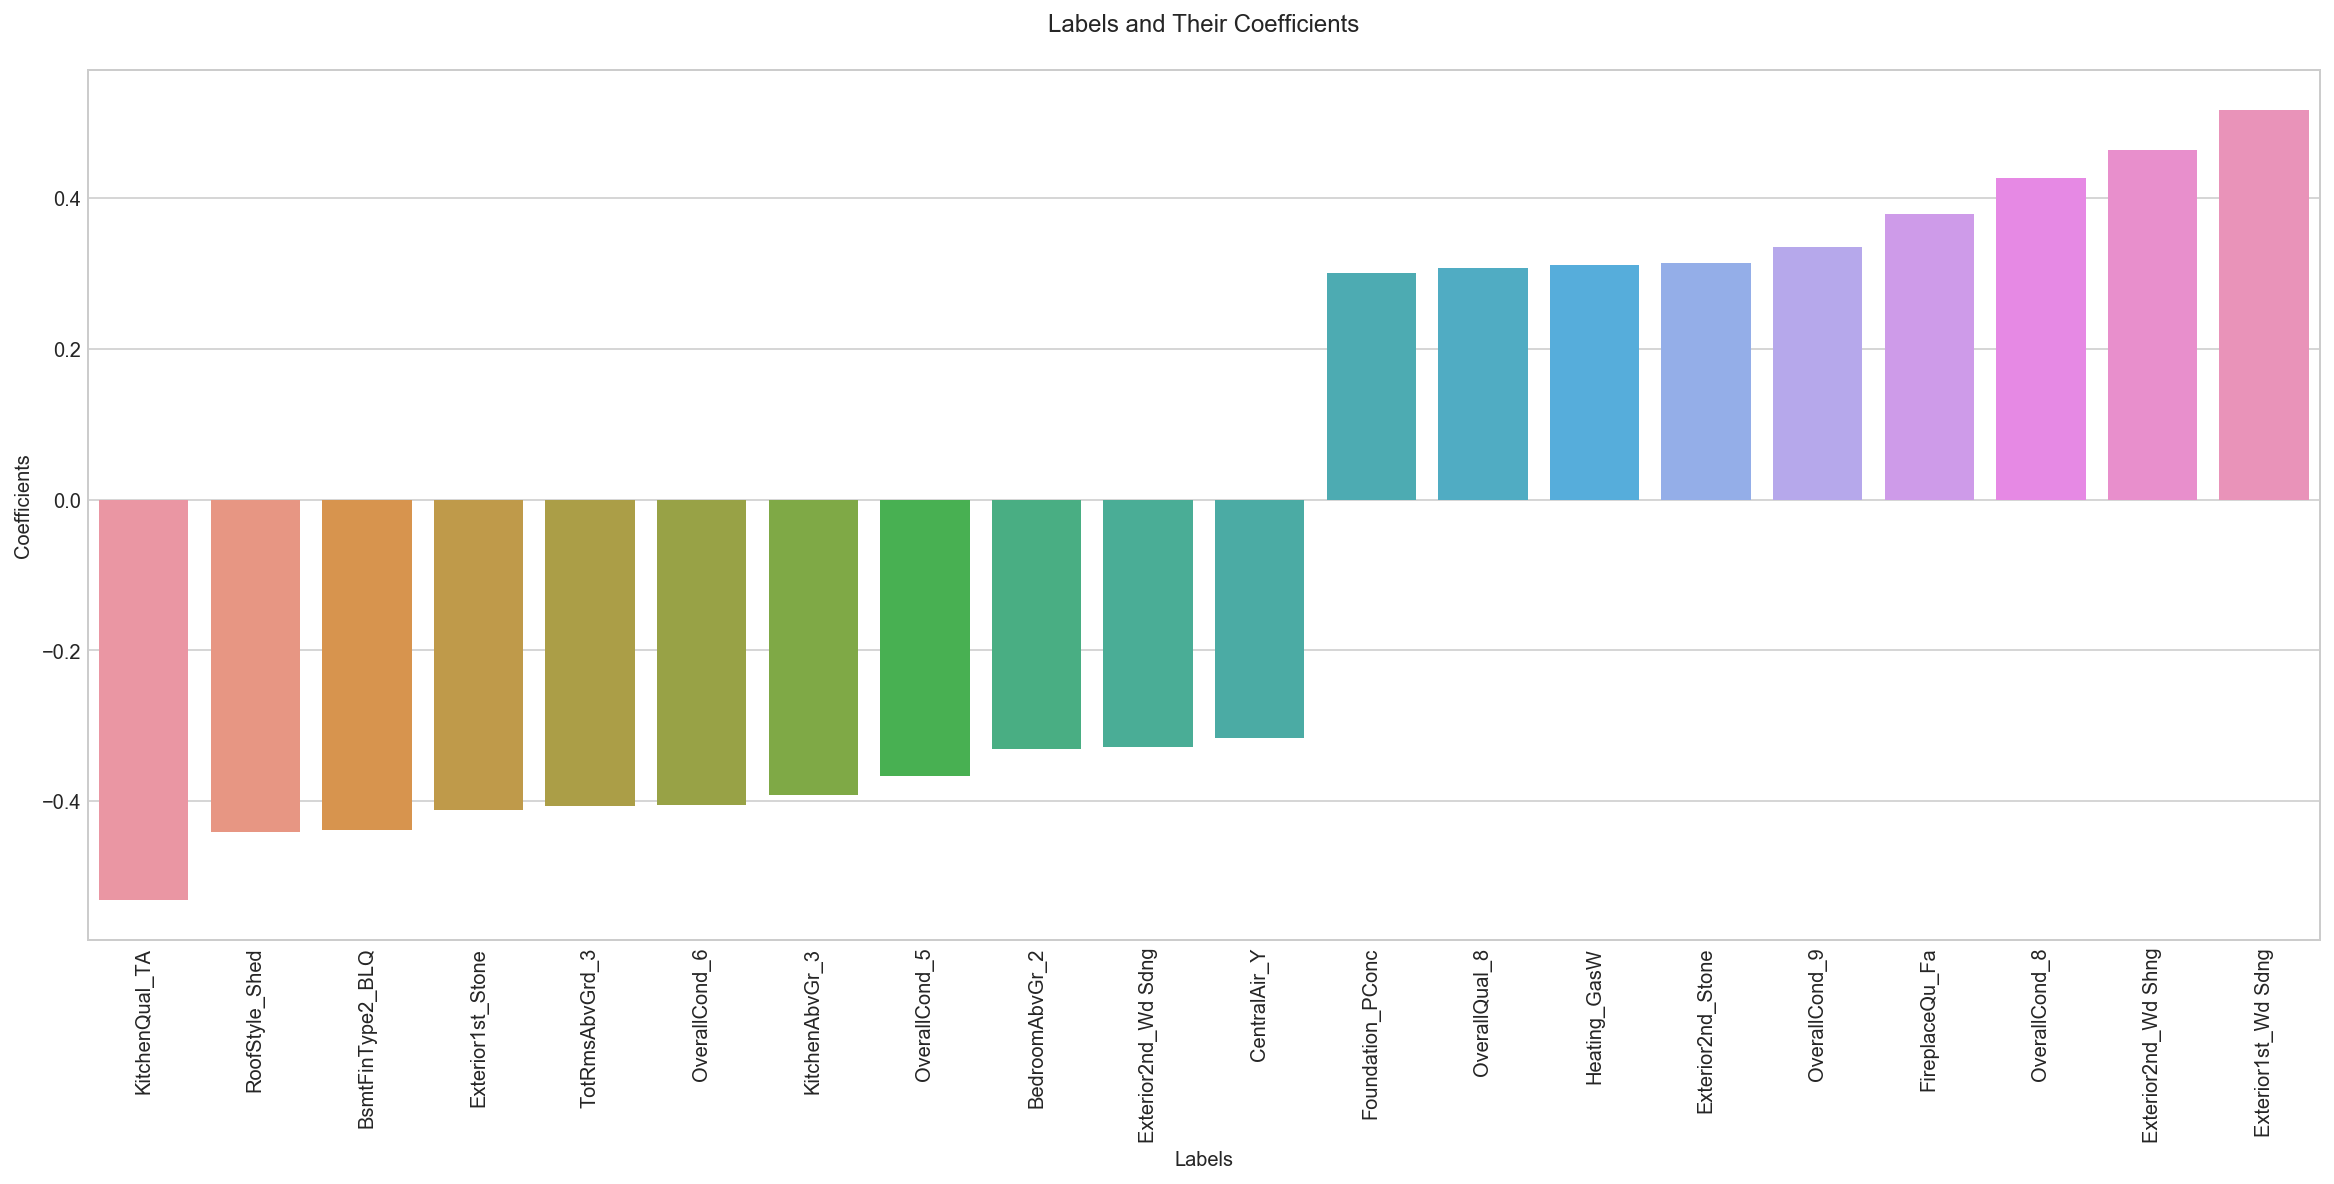

In [100]:
plt.figure(figsize=(20,8))
sns.barplot(data=lg_lasso_coef_df[(lg_lasso_coef_df['absolute_coef']!=0) & (lg_lasso_coef_df['absolute_coef']>0.3)].sort_values(by='coef', ascending=True),
            x='labels', y='coef')

plt.title('Labels and Their Coefficients\n')
plt.ylabel('Coefficients')
plt.xlabel('Labels')
plt.xticks(rotation='vertical')
plt.show()

> Hyperparameter tuning the L1 logistic regression model.

In [101]:
# LogisticRegressionCV with l1 to find the best C
lg_cv = LogisticRegressionCV(Cs=np.geomspace(0.001, 1.0, num=20), 
                             cv=5, 
                             penalty='l1', 
                             scoring='roc_auc',  
                             solver='liblinear')
lg_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([0.001  , 0.00144, 0.00207, 0.00298, 0.00428, 0.00616, 0.00886,
       0.01274, 0.01833, 0.02637, 0.03793, 0.05456, 0.07848, 0.11288,
       0.16238, 0.23357, 0.33598, 0.48329, 0.69519, 1.     ]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=0)

In [102]:
# With best C 
logreg_opt = LogisticRegression(C=lg_cv.C_[0], 
                                penalty='l1', 
                                solver='liblinear')
logreg_opt.fit(X_train,y_train)

LogisticRegression(C=0.4832930238571752, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [103]:
logreg_opt.score(X_test,y_test)

0.6746987951807228

In [104]:
# Check against cross_val_score
scores_logreg_opt = cross_val_score(logreg_opt, X, y, cv=5)
np.mean(scores_logreg_opt)

0.670933014354067

In [105]:
logreg_opt_mean_coef = np.mean(logreg_opt.coef_, axis=0)

In [106]:
logreg_opt_coef_df = pd.DataFrame({'labels':reno_features.columns.values[1:],'coef':logreg_opt_mean_coef,
                                 'absolute_coef':np.abs(logreg_opt_mean_coef)
                                })

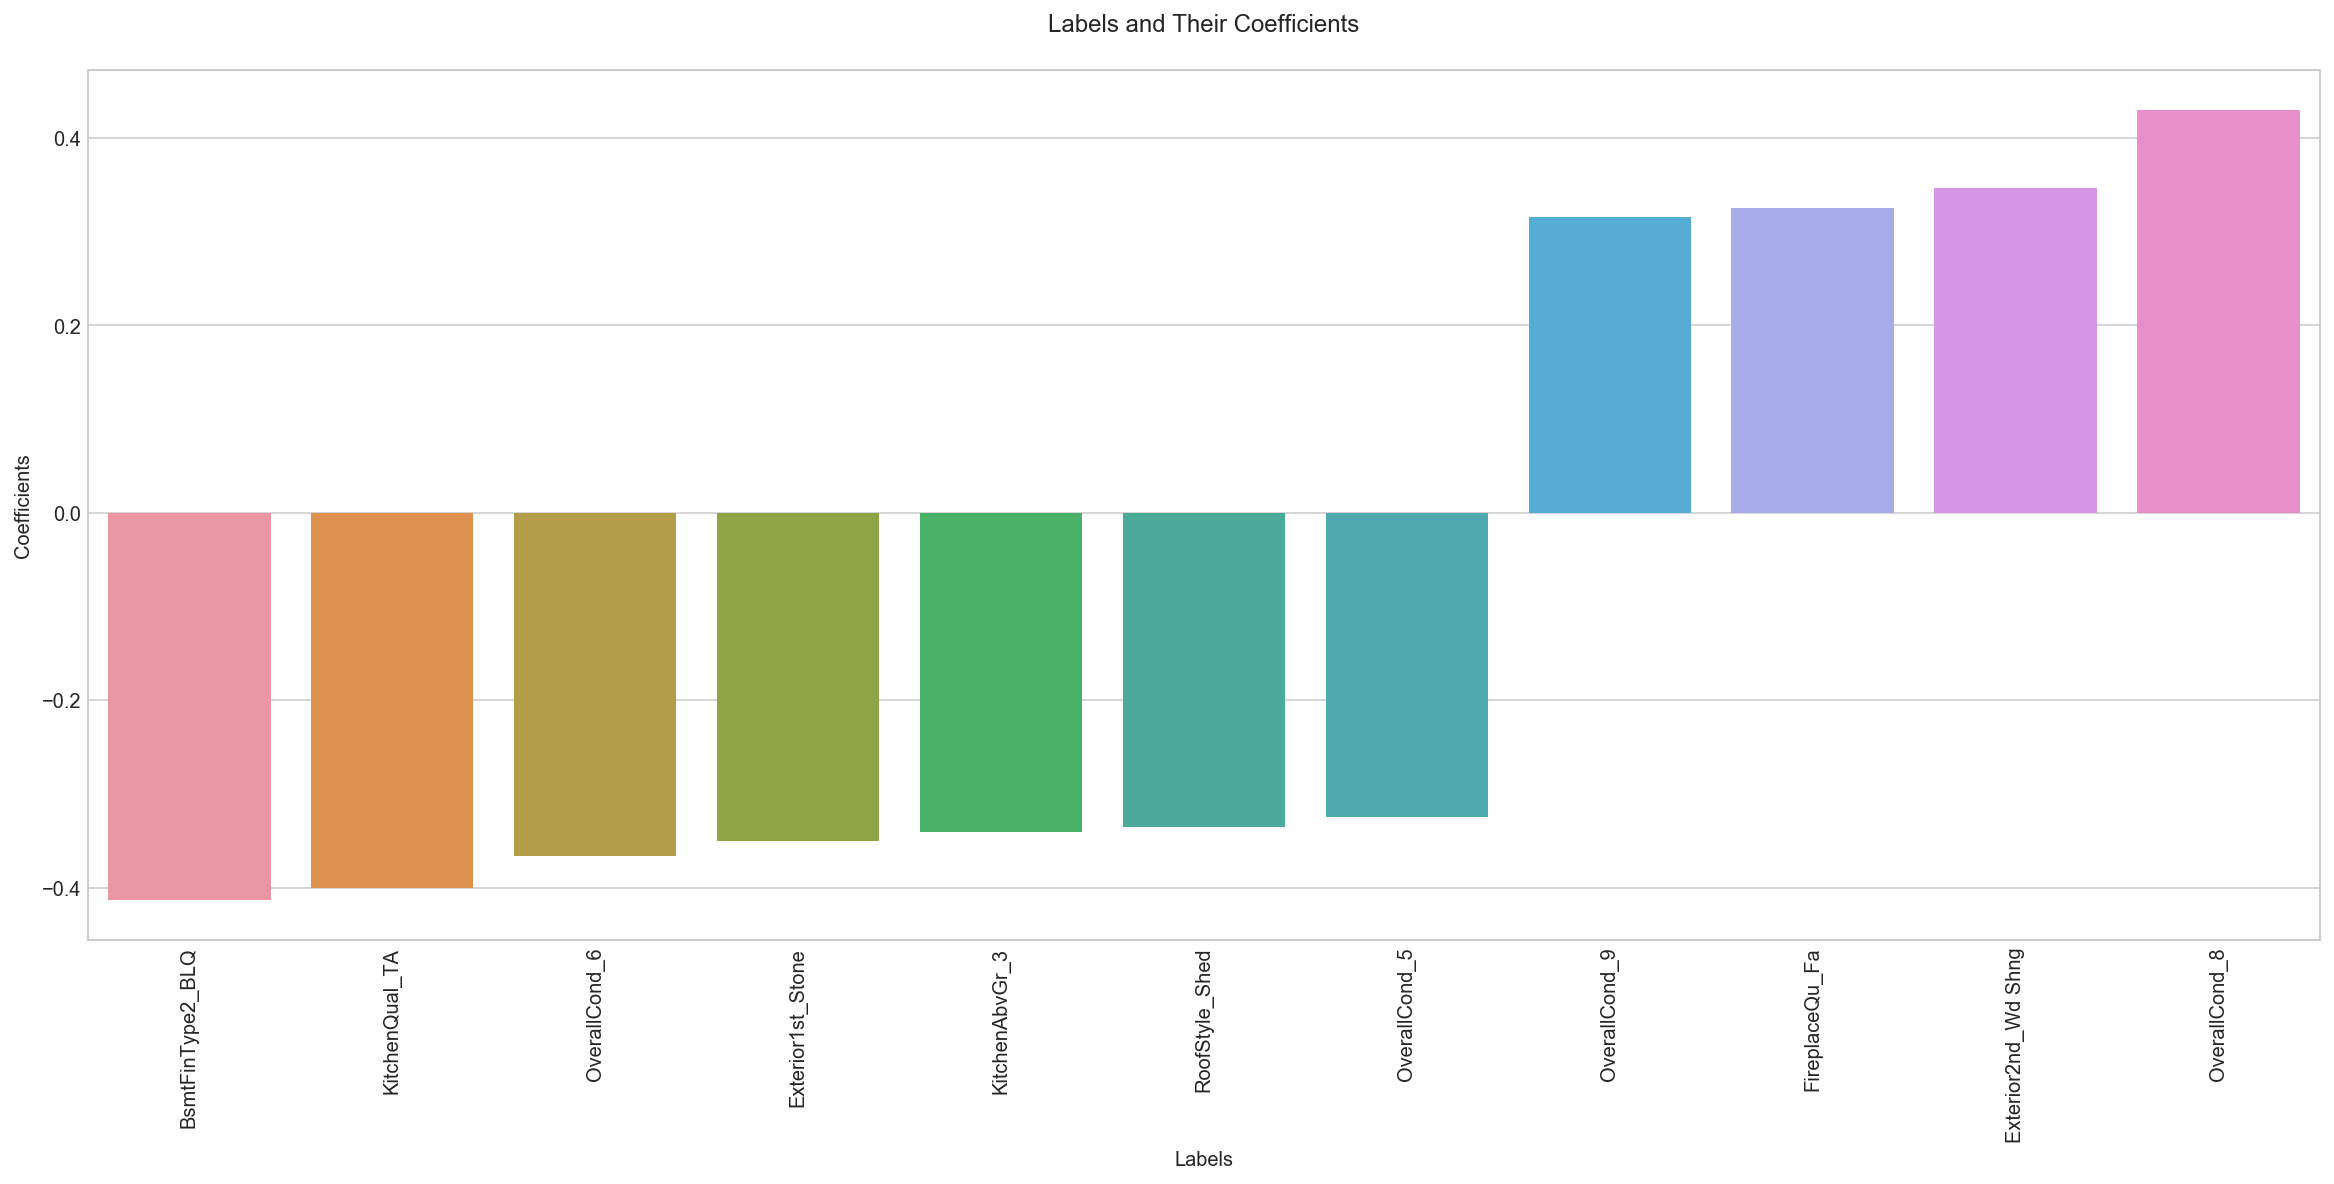

In [107]:
plt.figure(figsize=(20,8))
sns.barplot(data=logreg_opt_coef_df[(logreg_opt_coef_df['absolute_coef']!=0) & (logreg_opt_coef_df['absolute_coef']>0.3)].sort_values(by='coef', ascending=True),
            x='labels', y='coef')

plt.title('Labels and Their Coefficients\n')
plt.ylabel('Coefficients')
plt.xlabel('Labels')
plt.xticks(rotation='vertical')
plt.show()

In [108]:
logreg_opt_yhat = logreg_opt.predict(X_test)

In [109]:
print(classification_report(y_test, logreg_opt_yhat))

             precision    recall  f1-score   support

          0       0.68      0.64      0.66       163
          1       0.67      0.71      0.69       169

avg / total       0.67      0.67      0.67       332



Confusion matrix, without normalization
[[104  59]
 [ 49 120]]


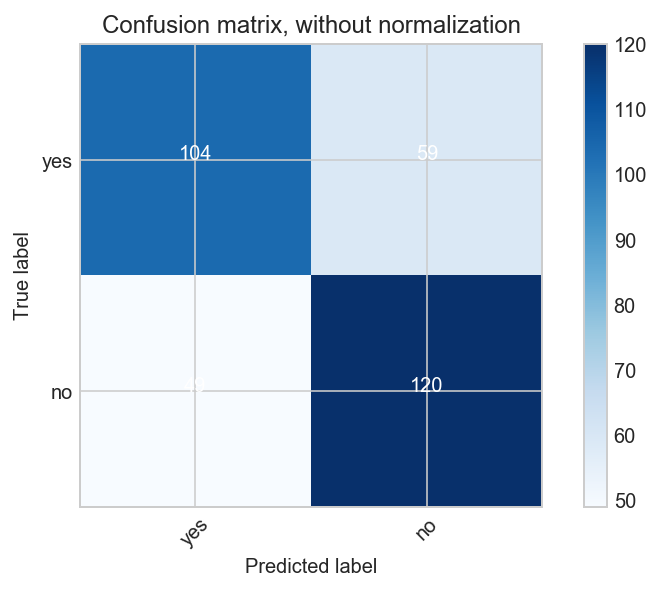

In [110]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, logreg_opt_yhat), classes=['yes','no'],
                      title='Confusion matrix, without normalization')

> Much better scores. False Positives are coming down.

In [111]:
# GridSearchCV with geomspace instead of logspace
# To test further
gs_grid = {'penalty': ['l2'],'C': np.geomspace(0.001, 1.0, num=50), 'solver': ['liblinear','lbfgs','sag','newton-cg']}

In [112]:
lr_gridsearch = GridSearchCV(LogisticRegression(), gs_grid, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc', max_iter=3000)

In [113]:
lr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    2.2s
/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Don

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l2'], 'C': array([0.001  , 0.00115, 0.00133, 0.00153, 0.00176, 0.00202, 0.00233,
       0.00268, 0.00309, 0.00356, 0.00409, 0.00471, 0.00543, 0.00625,
       0.0072 , 0.00829, 0.00954, 0.01099, 0.01265, 0.01456, 0.01677,
       0.01931, 0.02223, 0.0256 , 0.02947, 0.03393, 0...., 0.65513, 0.75431, 0.86851,
       1.     ]), 'solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [114]:
# best score on the training data:
lr_gridsearch.best_score_

0.731431954440424

In [115]:
# best parameters on the training data:
lr_gridsearch.best_params_

{'C': 0.014563484775012436, 'penalty': 'l2', 'solver': 'lbfgs'}

In [116]:
# assign the best estimator to a variable:
best_lr = lr_gridsearch.best_estimator_

In [117]:
# Score it on the testing data:
best_lr.score(X_test, y_test)

0.6716867469879518

In [118]:
best_lr_yhat = best_lr.predict(X_test)

In [119]:
print(classification_report(y_test, best_lr_yhat))

             precision    recall  f1-score   support

          0       0.67      0.64      0.66       163
          1       0.67      0.70      0.68       169

avg / total       0.67      0.67      0.67       332



Confusion matrix, without normalization
[[105  58]
 [ 51 118]]


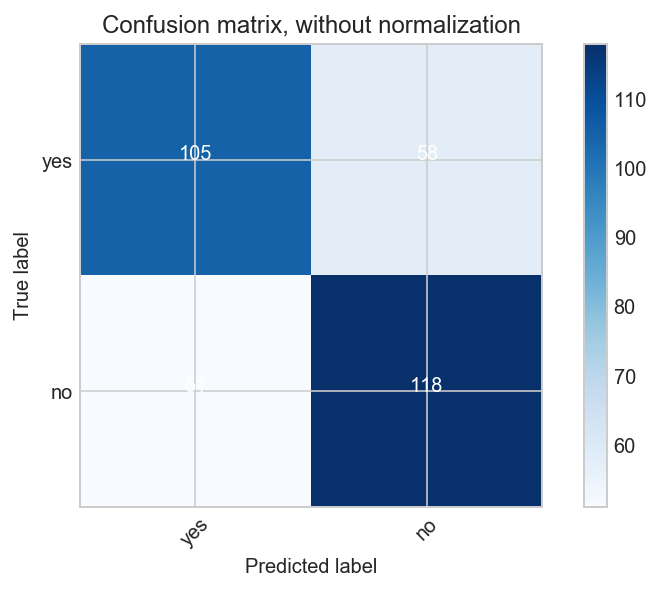

In [120]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, best_lr_yhat), classes=['yes','no'],
                      title='Confusion matrix, without normalization')

In [121]:
# Some SGDClassifier
sgd_cls_params = {
    'loss':['log','modified_huber'],
    'penalty':['l1','l2'],
    'alpha':np.logspace(-5,2,50)
}

sgd_cls = SGDClassifier()
sgd_cls_gs = GridSearchCV(sgd_cls, sgd_cls_params, cv=5, verbose=1, scoring='roc_auc')

In [122]:
sgd_cls_gs.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['log', 'modified_huber'], 'alpha': array([1.00000e-05, 1.38950e-05, 1.93070e-05, 2.68270e-05, 3.72759e-05,
       5.17947e-05, 7.19686e-05, 1.00000e-04, 1.38950e-04, 1.93070e-04,
       2.68270e-04, 3.72759e-04, 5.17947e-04, 7.19686e-04, 1.00000e-03,
   ... 1.38950e+01, 1.93070e+01,
       2.68270e+01, 3.72759e+01, 5.17947e+01, 7.19686e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [123]:
print(sgd_cls_gs.best_params_)
print(sgd_cls_gs.best_score_)
sgd_cls = sgd_cls_gs.best_estimator_

{'penalty': 'l2', 'alpha': 0.7196856730011514, 'loss': 'modified_huber'}
0.7303664974931228


In [124]:
sgd_cls.score(X_test,y_test)

0.6506024096385542

In [125]:
sgd_cls_yhat = sgd_cls.predict(X_test)

In [126]:
print(classification_report(y_test, sgd_cls_yhat))

             precision    recall  f1-score   support

          0       0.65      0.64      0.64       163
          1       0.65      0.66      0.66       169

avg / total       0.65      0.65      0.65       332



Confusion matrix, without normalization
[[104  59]
 [ 57 112]]


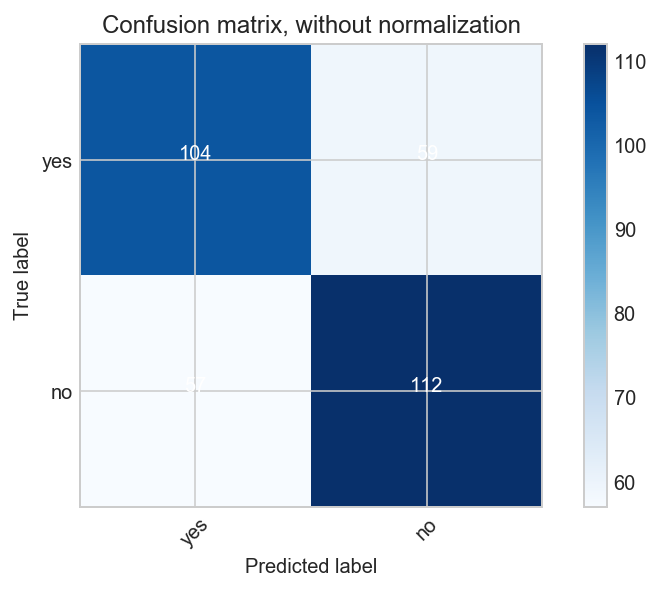

In [127]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, sgd_cls_yhat), classes=['yes','no'],
                      title='Confusion matrix, without normalization')

In [128]:
logreg_opt_yhat_pp = logreg_opt.predict_proba(X_test)
best_lr_yhat_pp = best_lr.predict_proba(X_test)
lg_lasso_yhat_pp = clf.predict_proba(X_test)
sgd_cls_yhat_pp = sgd_cls.predict_proba(X_test)

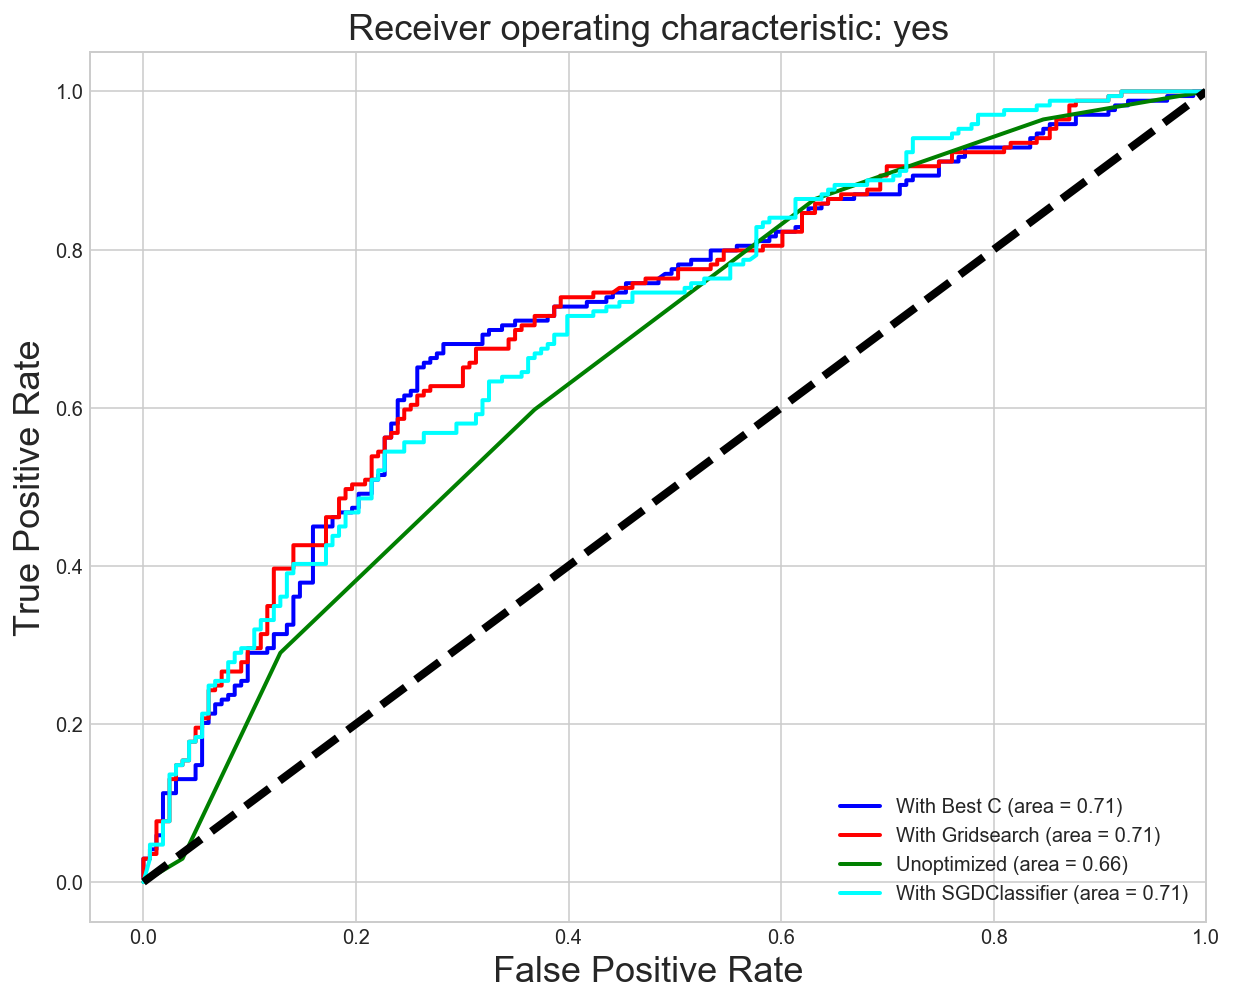

In [129]:
# ROC Curve but only if I change to binary classes (yes=1, no=0)

fpr, tpr, _ = roc_curve(y_test, logreg_opt_yhat_pp[:,1])
roc_auc = auc(fpr, tpr)

fpr_best, tpr_best, _ = roc_curve(y_test, best_lr_yhat_pp[:,1])
roc_auc_best = auc(fpr_best, tpr_best)

fpr_lg, tpr_lg, _ = roc_curve(y_test, lg_lasso_yhat_pp[:,1])
roc_auc_lg = auc(fpr_lg, tpr_lg)

fpr_sgd, tpr_sgd, _ = roc_curve(y_test, sgd_cls_yhat_pp[:,1])
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

# Initialize plot area
plt.figure(figsize=(10,8))

# The plots
plt.plot(fpr, tpr, label='With Best C (area = %0.2f)' % roc_auc, linewidth=2, color='blue')
plt.plot(fpr_best, tpr_best, label='With Gridsearch (area = %0.2f)' % roc_auc_best, linewidth=2, color='red')
plt.plot(fpr_lg, tpr_lg, label='Unoptimized (area = %0.2f)' % roc_auc_lg, linewidth=2, color='green')
plt.plot(fpr_sgd, tpr_sgd, label='With SGDClassifier (area = %0.2f)' % roc_auc_sgd, linewidth=2, color='cyan')

# The 0.5
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

# The make-look-pretty code
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: yes', fontsize=18)
plt.legend(loc="lower right")
plt.show()

> - Between Gridsearch and C values, it is a business decision to decide is having lower False Positives is the better option. There's a difference of 2-3 values between the two, and it is a case of which one is the better option.
> - I would recommend to use the SGDClassifier because it took the least amount of time along with L1 (with best C).

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [130]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [131]:
df['SaleCondition'].value_counts()

Normal     1194
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Partial       3
Name: SaleCondition, dtype: int64

In [132]:
# Check shapes
print('Reno Features: {}'.format(reno_features.shape))
print('Fixed Features: {}'.format(features.shape))

Reno Features: (1328, 166)
Fixed Features: (1328, 38)


In [133]:
challenge = pd.concat([features,reno_features,df['SaleCondition']], axis=1)

In [134]:
challenge.shape

(1328, 205)

In [135]:
# To make my life easier, so that I am dealing with binary imbalanced classes instead of imbalanced multiclasses, I'm dropping Family, Alloca, AdjLand, and Partial

challenge = challenge[~challenge['SaleCondition'].isin(['Family', 'Alloca', 'AdjLand','Partial'])]

In [136]:
class_names = ['Normal','Abnorml']

In [137]:
challenge.loc[(challenge['SaleCondition']=='Abnorml'), 'SaleCondition'] = 1
challenge.loc[(challenge['SaleCondition']=='Normal'), 'SaleCondition'] = 0

In [138]:
challenge['SaleCondition'] = challenge['SaleCondition'].astype('int64')

In [139]:
# Let's try 

X = challenge.iloc[:,:-1]
y = challenge['SaleCondition'].values

In [140]:
X = scaler.fit_transform(X)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [142]:
lr = LogisticRegression()

In [143]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [144]:
lr.score(X_test,y_test)

0.8930232558139535

In [145]:
scores_lr = cross_val_score(lr, X, y, cv=5, scoring='recall')
np.mean(scores_lr)

0.10368421052631578

In [146]:
print(classification_report(y_test, lr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.93      0.96      0.94       598
          1       0.13      0.09      0.10        47

avg / total       0.87      0.89      0.88       645



Confusion matrix, without normalization
[[572  26]
 [ 43   4]]


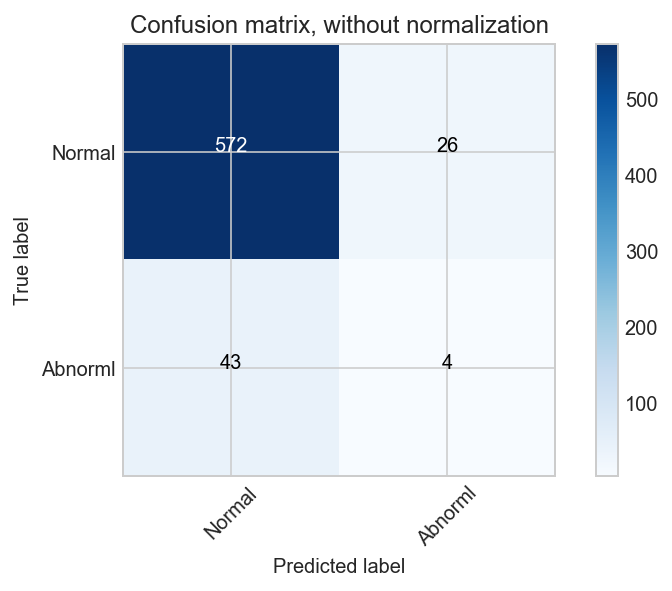

In [147]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, lr.predict(X_test)), classes=class_names,
                      title='Confusion matrix, without normalization')

> LOL yup. Well, this is my baseline.

In [148]:
# With penalty='l1', class_weight='balanced'

In [149]:
lr_bal = LogisticRegression(penalty='l1', class_weight='balanced')
lr_bal.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [150]:
lr_bal.score(X_test,y_test)

0.8077519379844961

In [151]:
scores_lr_bal = cross_val_score(lr_bal, X, y, cv=5, scoring='recall')
np.mean(scores_lr_bal)

0.33368421052631575

In [152]:
print(classification_report(y_test, lr_bal.predict(X_test)))

             precision    recall  f1-score   support

          0       0.93      0.86      0.89       598
          1       0.09      0.19      0.13        47

avg / total       0.87      0.81      0.84       645



Confusion matrix, without normalization
[[512  86]
 [ 38   9]]


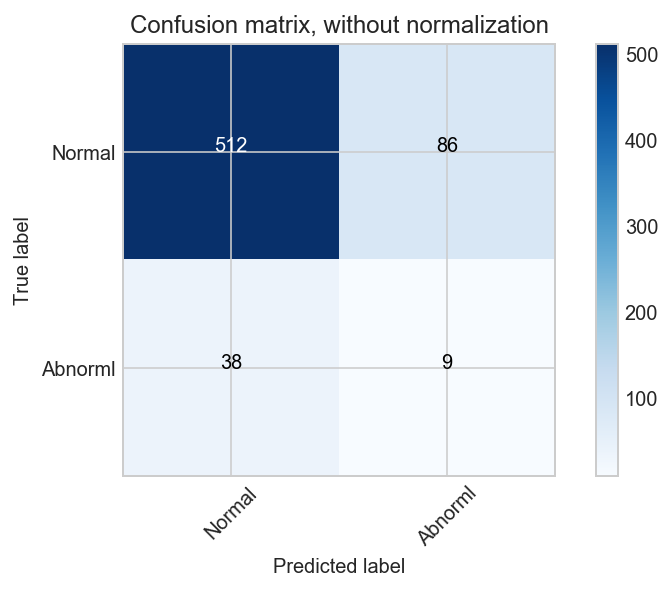

In [153]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, lr_bal.predict(X_test)), classes=class_names,
                      title='Confusion matrix, without normalization')

> Balanced is slightly better in detecting the Abnormal sales. Recall score from cross validation also got slightly better.

In [ ]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [ ]:
class_weight

In [ ]:
# Using GridSearchCV to go through multiple class weights and C

In [ ]:
weights = np.linspace(0.05, 0.95, 50)
gs_param = {'penalty': ['l1'],
            'C': np.geomspace(0.001, 1.0, num=50), 
            'solver': ['liblinear'], 
            'class_weight': [{1: x, 0: 1.0-x} for x in weights]}

In [ ]:
lr_weight = GridSearchCV(LogisticRegression(), gs_param, cv=5, verbose=1, n_jobs=-1, scoring='recall')
lr_weight.fit(X_train,y_train)

In [ ]:
lr_weight.best_params_

In [ ]:
best_lr_weight = lr_weight.best_estimator_

In [ ]:
best_lr_weight.score(X_test,y_test)

In [ ]:
print(classification_report(y_test, best_lr_weight.predict(X_test)))

In [ ]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, best_lr_weight.predict(X_test)), classes=class_names,
                      title='Confusion matrix, without normalization')

In [ ]:
lr_coef_df = pd.DataFrame({'coef':best_lr_weight.coef_[0], 'labels':challenge.iloc[:,:-1].columns.values, 'abs_coef': np.abs(best_lr_weight.coef_[0])})

In [ ]:
lr_coef_df[lr_coef_df['coef']!=0].sort_values(by='abs_coef', ascending=False)

> Features of abnormal sale: Unfinished Garage(GarageFinish_Unf) and Fence with Minimum Privacy (Fence_MnPrv).

In [ ]:
# KAPPAAAAAA~~~

In [ ]:
from sklearn.metrics import cohen_kappa_score, make_scorer

weights = np.linspace(0.05, 0.95, 20)

kappa_scorer = make_scorer(cohen_kappa_score)

kappa_param = {'penalty': ['l1','l2'],
               'C': np.geomspace(0.001, 1.0, num=20), 
               'solver': ['liblinear'],
               'class_weight': [{1: x, 0: 1.0-x} for x in weights]
              }

kappa_grid = GridSearchCV(LogisticRegression(), kappa_param, cv=5, scoring=kappa_scorer, verbose=1, n_jobs=-1)

In [ ]:
kappa_grid.fit(X_train, y_train)

In [157]:
kappa_grid.best_params_

{'C': 0.42919342601287785,
 'class_weight': {0: 0.08673469387755106, 1: 0.9132653061224489},
 'penalty': 'l1',
 'solver': 'liblinear'}

In [158]:
kappa = kappa_grid.best_estimator_

In [159]:
kappa.score(X_test,y_test)

0.7271317829457364

In [160]:
print(classification_report(y_test, kappa.predict(X_test)))

             precision    recall  f1-score   support

          0       0.93      0.77      0.84       598
          1       0.07      0.23      0.11        47

avg / total       0.86      0.73      0.79       645



Confusion matrix, without normalization
[[458 140]
 [ 36  11]]


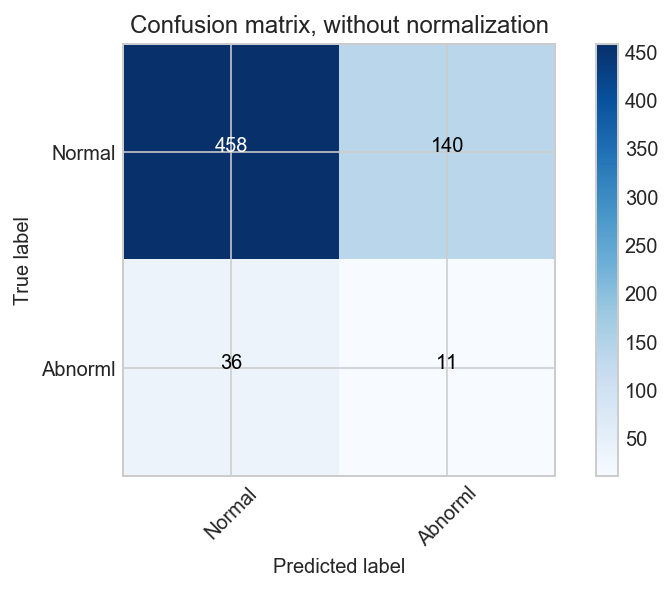

In [161]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, kappa.predict(X_test)), classes=class_names,
                      title='Confusion matrix, without normalization')